In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy.ma as ma
import glob
from collections import namedtuple, OrderedDict
import netCDF4 as nc
import os
import scipy
import scipy.io as sio
from scipy import interpolate, signal
from pyproj import Proj,transform
import sys
sys.path.append('/ocean/ssahu/CANYONS/wcvi/grid/')
from bathy_common import *
from matplotlib import path
from salishsea_tools import viz_tools
import xarray as xr
from salishsea_tools import nc_tools
import scipy.io as sio
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import cmocean as cmo
import matplotlib.gridspec as gridspec
%matplotlib inline
from scipy.io import loadmat
from scipy.interpolate import griddata
from dateutil.parser import parse
from salishsea_tools import geo_tools, viz_tools, tidetools, nc_tools

import seaborn as sns
from windrose import plot_windrose
from windrose import WindroseAxes


from dateutil        import parser
from datetime import datetime

/home/ssahu/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:9: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
sns.set_context('poster')
sns.set_style('dark')

In [50]:
sns.set()

In [3]:
newport_data = pd.read_table('/data/ssahu/Falkor_2013/winds/Newport_winds_unfiltered.csv', delim_whitespace=1, parse_dates= True, header = None, skiprows=2)

# a = orford_data[0].str.split(',', expand=True)

# b = orford_data[1].str.split(',', expand=True)

# df_La_Peruse = pd.concat([a, b], axis=1)

df_cut = newport_data.drop(newport_data.columns[7:], axis=1)
columns = ['Year','Month','Day','Hour','Min','Wind Direction (deg)','Wind Speed','GDR','GST','GTIME']
effective = columns[:7]
df_cut.columns = effective


df_cut['Year']   = df_cut['Year'].astype(str)
df_cut['Day']    = df_cut['Day'].astype(str)
df_cut['Month']  = df_cut['Month'].astype(str)
df_cut['Hour']   = df_cut["Hour"].astype(str)

df_cut.columns = df_cut.columns.str.replace(' ', '')



df_cut['Datetime'] = df_cut['Year'] + "-" + df_cut['Month'] + "-" + df_cut['Day']+ " " + df_cut["Hour"] + ":00:00"

df_cut["Datetime"] = pd.to_datetime(df_cut["Datetime"])


df_cut = df_cut.iloc[:,4:]

df_cut = df_cut.set_index(pd.DatetimeIndex(df_cut["Datetime"]))


# df_cut.tail(10)

df_subset = df_cut.loc['2013-08-01 00:00:00':'2013-09-01 00:00:00']

df_subset = df_subset.resample('60T').mean().reset_index()

df_subset.head(10)

Datetime   Min  WindDirection(deg)  WindSpeed
0 2013-08-01 00:00:00  25.0          208.333333   1.866667
1 2013-08-01 01:00:00  25.0          181.333333   1.983333
2 2013-08-01 02:00:00  25.0          206.500000   1.600000
3 2013-08-01 03:00:00  25.0          223.333333   2.100000
4 2013-08-01 04:00:00  25.0          251.166667   2.483333
5 2013-08-01 05:00:00  25.0          224.833333   1.866667
6 2013-08-01 06:00:00  25.0          245.666667   1.950000
7 2013-08-01 07:00:00  25.0          240.500000   2.150000
8 2013-08-01 08:00:00  25.0          233.000000   2.050000
9 2013-08-01 09:00:00  25.0          217.666667   1.850000

In [4]:
ws_newport = df_subset['WindSpeed']
wd_newport = df_subset['WindDirection(deg)']


u_wind_newport = np.multiply(ws_newport[:],np.cos(wd_newport))

v_wind_newport = np.multiply(ws_newport[:],np.sin(wd_newport))

In [5]:
La_Peruse_data = pd.read_table('/data/ssahu/Falkor_2013/winds/La_persue_wave_buoy.csv',delim_whitespace=1,header = None, skiprows=7)

a = La_Peruse_data[0].str.split(',', expand=True)

b = La_Peruse_data[1].str.split(',', expand=True)

df_La_Peruse = pd.concat([a, b], axis=1)

df_cut = df_La_Peruse.drop(df_La_Peruse.columns[14:], axis=1)

columns = ['STN_ID','DATE','TIME','Qflag','LATITUDE','LONGITUDE','DEPTH','VCAR','VTPK','VWH','VCMX','VTP','WDIR','WSPD','WSS','GSPD','WDIR','WSPD','WSS','GSPD','ATMS','ATMS','DRYT','SSTP']

effective = columns[:14]

df_cut.columns = effective
df_cut = df_cut.drop('Qflag',axis =1)

df_cut['Date_time']= df_cut['DATE'] + " "+ df_cut['TIME']

# df_cut = df_cut.drop('DATE', axis=1)
# df_cut = df_cut.drop('TIME', axis=1)

df_cut.tail(10)

STN_ID        DATE   TIME LATITUDE LONGITUDE  DEPTH  VCAR   VTPK  \
217132  C46206  06/18/2018  18:38    48.83    126.00  72.00  2.19  12.80   
217133  C46206  06/18/2018  19:38    48.83    126.00  72.00  2.04  12.80   
217134  C46206  06/19/2018  00:38    48.83    126.00  72.00  1.76  12.19   
217135  C46206  06/19/2018  04:38    48.83    126.00  72.00  1.66  12.19   
217136  C46206  06/19/2018  05:38    48.83    126.00  72.00  1.51  12.19   
217137  C46206  06/19/2018  06:38    48.83    126.00  72.00  1.59  11.13   
217138  C46206  06/19/2018  13:38    48.83    126.00  72.00  1.51  11.64   
217139  C46206  06/19/2018  17:38    48.83    126.00  72.00  1.50  11.13   
217140  C46206  06/19/2018  18:38    48.83    126.00  72.00  1.45  15.06   
217141  C46206  06/19/2018  21:38    48.83    126.00  72.00  1.47  10.67   

         VWH  VCMX    VTP    WDIR  WSPD         Date_time  
217132  2.20  6.40  12.80   58.00  3.50  06/18/2018 18:38  
217133  2.00  3.80  12.80   64.00  3.70  06/18/2018 19:38  
217134  1.80  2.60  12.20  155.00  2.60  06/19/2018 00:38  
217135  1.70  2.70  12.20   86.00  2.60  06/19/2018 04:38  
217136  1.50  2.40  12.20   65.00  3.50  06/19/2018 05:38  
217137  1.60  2.80  11.10   64.00  4.80  06/19/2018 06:38  
217138  1.40  7.10  11.60   51.00  4.60  06/19/2018 13:38  
217139  1.30  7.00  11.10   72.00  4.20  06/19/2018 17:38  
217140  1.40  5.20  15.10   84.00  3.40  06/19/2018 18:38  
217141  1.50  2.10  10.70   87.00  2.50  06/19/2018 21:38

In [6]:
LA_PERUSE_array = df_cut.as_matrix()

start_index_2013_June  = np.transpose(np.array(np.where(LA_PERUSE_array[:,1] == '08/01/2013')))[0,0]

end_index_2013_September  = np.transpose(np.array(np.where(LA_PERUSE_array[:,1] == '08/31/2013')))[-1,0]


In [7]:
wind_spd = LA_PERUSE_array[start_index_2013_June:end_index_2013_September,-2].astype(np.float)

wind_dir = LA_PERUSE_array[start_index_2013_June:end_index_2013_September,-3].astype(np.float)

u_wind = np.multiply(wind_spd[:],np.cos(wind_dir))

v_wind = np.multiply(wind_spd[:],np.sin(wind_dir))

time_2013 = LA_PERUSE_array[start_index_2013_June:end_index_2013_September,-1].astype(str)

datetime_2013 = np.empty_like(time_2013)

for i in np.arange(datetime_2013.shape[0]):
    datetime_2013[i] = datetime.strptime(time_2013[i], '%m/%d/%Y %H:%M')
    
datetime_2013 = datetime_2013.astype(np.datetime64)

/home/ssahu/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:973: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


AttributeError: 'NoneType' object has no attribute 'remove'

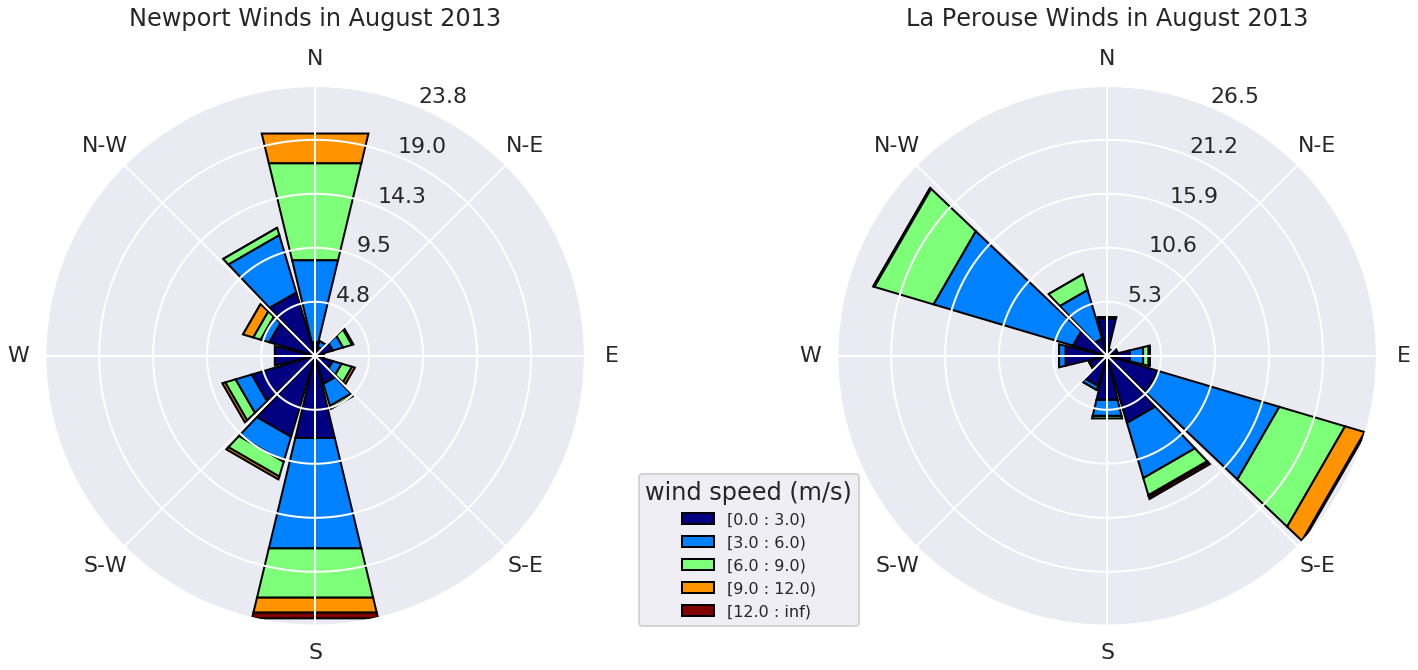

In [10]:

ws_newport = df_subset['WindSpeed']
wd_newport = df_subset['WindDirection(deg)']

ws_La_Perouse = wind_spd
wd_La_Perouse = wind_dir


fig = plt.figure(figsize=(20, 10))
left_rectangle = [0, 0.1, 0.4, 0.75]# [left, bottom, width, height] as a fraction of total figure size
ax1 = WindroseAxes(fig, left_rectangle)  
fig.add_axes(ax1)# creates the axes of specified dimensions

ax1.bar(wd_newport, ws_newport, normed=True, nsector=12, opening=0.9, edgecolor='black', bins=np.arange(0,14,3))#[0,2.5,4.5,8,10,11])
ax1.set_title("Newport Winds in August 2013", position=(0.5, 1.1))
ax1.set_legend()
ax1.legend(title="wind speed (m/s)", loc=(1.1, 0), fontsize =16)

right_rectangle = [0.5, 0.1, 0.5, 0.75]     # [left, bottom, width, height]
ax = WindroseAxes(fig, right_rectangle)
fig.add_axes(ax)
ax.bar(wd_La_Perouse, ws_La_Perouse, normed=True, nsector=12,opening=0.9, edgecolor='black', bins=np.arange(0,14,3))#[0,2.5,4.5,8,10,11])
ax.set_title("La Perouse Winds in August 2013", position=(0.5, 1.1))
# ax.legend(None)
# ax.set_legend(False)
ax.get_legend().remove()
# ax.legend(title="wind speed (m/s)", loc=(1.1, 0), fontsize =16)

In [124]:
La_Peruse_data = pd.read_table('/data/ssahu/Falkor_2013/winds/La_persue_wave_buoy.csv',delim_whitespace=1,header = None, skiprows=7)

a = La_Peruse_data[0].str.split(',', expand=True)

b = La_Peruse_data[1].str.split(',', expand=True)

df_La_Peruse = pd.concat([a, b], axis=1)

df_cut = df_La_Peruse.drop(df_La_Peruse.columns[14:], axis=1)

columns = ['STN_ID','DATE','TIME','Qflag','LATITUDE','LONGITUDE','DEPTH','VCAR','VTPK','VWH','VCMX','VTP','WDIR','WSPD','WSS','GSPD','WDIR','WSPD','WSS','GSPD','ATMS','ATMS','DRYT','SSTP']

effective = columns[:14]

df_cut.columns = effective
df_cut = df_cut.drop('Qflag',axis =1)

df_cut['Date_time']= df_cut['DATE'] + " "+ df_cut['TIME']

# df_cut = df_cut.drop('DATE', axis=1)
# df_cut = df_cut.drop('TIME', axis=1)

df_cut.tail(10)

STN_ID        DATE   TIME LATITUDE LONGITUDE  DEPTH  VCAR   VTPK  \
217132  C46206  06/18/2018  18:38    48.83    126.00  72.00  2.19  12.80   
217133  C46206  06/18/2018  19:38    48.83    126.00  72.00  2.04  12.80   
217134  C46206  06/19/2018  00:38    48.83    126.00  72.00  1.76  12.19   
217135  C46206  06/19/2018  04:38    48.83    126.00  72.00  1.66  12.19   
217136  C46206  06/19/2018  05:38    48.83    126.00  72.00  1.51  12.19   
217137  C46206  06/19/2018  06:38    48.83    126.00  72.00  1.59  11.13   
217138  C46206  06/19/2018  13:38    48.83    126.00  72.00  1.51  11.64   
217139  C46206  06/19/2018  17:38    48.83    126.00  72.00  1.50  11.13   
217140  C46206  06/19/2018  18:38    48.83    126.00  72.00  1.45  15.06   
217141  C46206  06/19/2018  21:38    48.83    126.00  72.00  1.47  10.67   

         VWH  VCMX    VTP    WDIR  WSPD         Date_time  
217132  2.20  6.40  12.80   58.00  3.50  06/18/2018 18:38  
217133  2.00  3.80  12.80   64.00  3.70  06/18/2018 19:38  
217134  1.80  2.60  12.20  155.00  2.60  06/19/2018 00:38  
217135  1.70  2.70  12.20   86.00  2.60  06/19/2018 04:38  
217136  1.50  2.40  12.20   65.00  3.50  06/19/2018 05:38  
217137  1.60  2.80  11.10   64.00  4.80  06/19/2018 06:38  
217138  1.40  7.10  11.60   51.00  4.60  06/19/2018 13:38  
217139  1.30  7.00  11.10   72.00  4.20  06/19/2018 17:38  
217140  1.40  5.20  15.10   84.00  3.40  06/19/2018 18:38  
217141  1.50  2.10  10.70   87.00  2.50  06/19/2018 21:38

In [125]:
LA_PERUSE_array = df_cut.as_matrix()

start_index_2013_June  = np.transpose(np.array(np.where(LA_PERUSE_array[:,1] == '06/01/2013')))[0,0]

end_index_2013_September  = np.transpose(np.array(np.where(LA_PERUSE_array[:,1] == '08/31/2013')))[-1,0]


In [126]:
wind_spd = LA_PERUSE_array[start_index_2013_June:end_index_2013_September,-2].astype(np.float)

wind_dir = LA_PERUSE_array[start_index_2013_June:end_index_2013_September,-3].astype(np.float)

u_wind = np.multiply(wind_spd[:],np.cos(wind_dir))

v_wind = np.multiply(wind_spd[:],np.sin(wind_dir))

time_2013 = LA_PERUSE_array[start_index_2013_June:end_index_2013_September,-1].astype(str)

datetime_2013 = np.empty_like(time_2013)

for i in np.arange(datetime_2013.shape[0]):
    datetime_2013[i] = datetime.strptime(time_2013[i], '%m/%d/%Y %H:%M')
    
datetime_2013 = datetime_2013.astype(np.datetime64)

In [23]:
range = pd.date_range('2013-08-01', '2013-08-31', freq='D')



La_perouse_series = pd.Series(v_wind, index=datetime_2013)
daily_north_La_Perouse = La_perouse_series.resample('D').mean()

La_perouse_stress_daily = np.sign(daily_north_La_Perouse)*stress(sp=daily_north_La_Perouse)


In [ ]:

step = 1
window_size_1 = 24



time_axis = datetime_2013[::step]


s_v_newport = v_wind_newport[:]   
filt_v_newport = smooth(s_v_newport,window_size_1,'hanning')
Newport_stress = np.sign(filt_v_newport)*stress(sp=filt_v_newport)



s_v = v_wind[:]   
filt_v = smooth(s_v,window_size_1,'hanning')
La_perouse_stress = np.sign(filt_v)*stress(sp=filt_v)




fig, ax1 = plt.subplots(1, 1, figsize=(18,8))

# ax1.plot(time_axis[1300:] ,filt_v[1300:], 'b-',linewidth=2, label = 'La Perouse')

# ax1.plot(time_axis[1300:] , La_perouse_stress[1300:], color = colors[30],linewidth=2, label = 'La Perouse')
ax1.plot(mydates_Newport[211:-121] , La_perouse_stress_daily, color = colors[30],linewidth=2, label = 'La Perouse')
# ax1.plot(df_subset['Datetime'], Newport_stress, c = colors[40], linewidth=2, label = 'Newport')
ax1.plot(mydates_Newport[207:-116], wind_stress_newport[207:-116], c = colors[40], linewidth=2, label = 'Newport')
# ax1.plot(time_axis_orford ,filt_v_orford[::step], 'cyan',linewidth=2)


# ax1.legend(['Filtered'])
# ax1.set_title("Meridional Wind speed", fontsize = 16)
ax1.axhline(y=0, color = 'k')
# ax1.axvline(x = time_axis[time_axis == '2013-08-21'], color = 'r', linestyle  = '--')
ax1.axvline(x = mydates_Newport[mydates_Newport == '2013-08-21'], color = 'r', linestyle  = '--')
ax1.axvline(x = time_axis[-1], color = 'r', linestyle  = '--')
ax1.tick_params(axis='both',labelsize =16)
ax1.set_ylim(-0.11,0.11)
ax1.set_ylabel('Meridional Wind Stress ($N/m^2$)', fontsize = 16)# and Wind stress (*10^3) (N/m^2)', fontsize = 16)
ax1.grid()
ax1.yaxis.label.set_color(colors[35])
ax1.tick_params(axis='both',labelsize =16, color = colors[35])

ax2 = ax1.twinx()
ax2.plot(mydates[90:-50], v_unrotated[90:-50,10,j,i], c = colors_speed[40], linewidth=2, label = '{0:0.1f}m depth'.format(zlevels[10]))
ax2.plot(mydates[90:-50], v_unrotated[90:-50,22,j,i], c = colors_speed[25], linewidth=1, label = '{0:0.1f}m depth'.format(zlevels[22]))
ax2.plot(mydates[90:-50], v_unrotated[90:-50,25,j,i], c = colors_speed[30], linewidth=1.5, label = '{0:0.1f}m depth'.format(zlevels[25]))


ax2.plot(mydates_A1_1, north_148, color = colors_speed[35], linewidth=1.5, linestyle = 'dashed', label = 'ADCP {0:0.1f}m depth'.format(148))

north_84[north_84 < -2] = 'Nan'
ax2.plot(mydates_A1_1, north_84, color = colors_speed[25], linewidth=1.5,linestyle = 'dashed', label = 'ADCP {0:0.1f}m depth'.format(84))
# # ax3 = ax1.twinx()
# # ax1.plot(mydates_Newport[1:-1], wind_stress_newport[:])#, 'golden', linewidth=2, label = 'Newport')
# # ax3.set_yticklabels([])

ax2.set_ylabel('Alongshore current (m/sec)', fontsize = 16)
ax2.set_ylim(-0.5, 0.5)
ax2.tick_params(axis='both',labelsize =16, color = colors_speed[25])
ax2.yaxis.label.set_color(colors_speed[25])
ax2.legend(loc = 'upper left', fontsize  =14)
ax2.spines['right'].set_color(colors_speed[25])



# offset = 60
# new_fixed_axis = ax2.get_grid_helper().new_fixed_axis
# ax2.axis["right"] = new_fixed_axis(loc="right",
#                                     axes=ax2,
#                                     offset=(offset, 0))
ax1.legend(loc='best', fontsize = 14)
fig.autofmt_xdate()



/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:198: RuntimeWarning: invalid value encountered in greater
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:203: RuntimeWarning: invalid value encountered in less
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:206: RuntimeWarning: invalid value encountered in greater
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in less


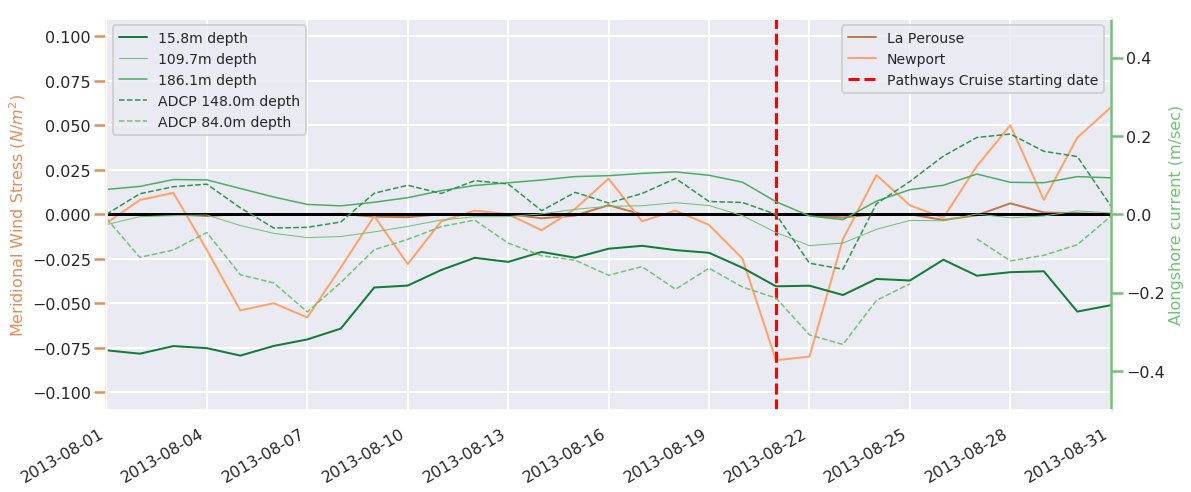

In [42]:

step = 1
window_size_1 = 24



time_axis = datetime_2013[::step]


s_v_newport = v_wind_newport[:]   
filt_v_newport = smooth(s_v_newport,window_size_1,'hanning')
Newport_stress = np.sign(filt_v_newport)*stress(sp=filt_v_newport)



s_v = v_wind[:]   
filt_v = smooth(s_v,window_size_1,'hanning')
La_perouse_stress = np.sign(filt_v)*stress(sp=filt_v)




fig, ax1 = plt.subplots(1, 1, figsize=(18,8))

# ax1.plot(time_axis[1300:] ,filt_v[1300:], 'b-',linewidth=2, label = 'La Perouse')

# ax1.plot(time_axis[1300:] , La_perouse_stress[1300:], color = colors[30],linewidth=2, label = 'La Perouse')
ax1.plot(mydates_Newport[211:-121] , La_perouse_stress_daily, color = colors[30],linewidth=2, label = 'La Perouse')
# ax1.plot(df_subset['Datetime'], Newport_stress, c = colors[40], linewidth=2, label = 'Newport')
ax1.plot(mydates_Newport[207:-116], wind_stress_newport[207:-116], c = colors[40], linewidth=2, label = 'Newport')
# ax1.plot(time_axis_orford ,filt_v_orford[::step], 'cyan',linewidth=2)


# ax1.legend(['Filtered'])
# ax1.set_title("Meridional Wind speed", fontsize = 16)
ax1.axhline(y=0, color = 'k')
# ax1.axvline(x = time_axis[time_axis == '2013-08-21'], color = 'r', linestyle  = '--')
ax1.axvline(x = mydates_Newport[mydates_Newport == '2013-08-21'], color = 'r', linestyle  = '--', label = 'Pathways Cruise starting date')
ax1.axvline(x = time_axis[-1], color = 'r', linestyle  = '--')
ax1.tick_params(axis='both',labelsize =16)
ax1.set_ylim(-0.11,0.11)
ax1.set_ylabel('Meridional Wind Stress ($N/m^2$)', fontsize = 16)# and Wind stress (*10^3) (N/m^2)', fontsize = 16)
ax1.grid()
ax1.yaxis.label.set_color(colors[35])
ax1.spines['left'].set_color(colors[35])
ax1.tick_params(axis='both',labelsize =16, color = colors[35])

ax2 = ax1.twinx()
ax2.plot(mydates[90:-50], v_unrotated[90:-50,10,j,i], c = colors_speed[40], linewidth=2, label = '{0:0.1f}m depth'.format(zlevels[10]))
ax2.plot(mydates[90:-50], v_unrotated[90:-50,22,j,i], c = colors_speed[25], linewidth=1, label = '{0:0.1f}m depth'.format(zlevels[22]))
ax2.plot(mydates[90:-50], v_unrotated[90:-50,25,j,i], c = colors_speed[30], linewidth=1.5, label = '{0:0.1f}m depth'.format(zlevels[25]))


ax2.plot(mydates_A1_1, north_148, color = colors_speed[35], linewidth=1.5, linestyle = 'dashed', label = 'ADCP {0:0.1f}m depth'.format(148))

north_84[north_84 < -2] = 'Nan'
ax2.plot(mydates_A1_1, north_84, color = colors_speed[25], linewidth=1.5,linestyle = 'dashed', label = 'ADCP {0:0.1f}m depth'.format(84))
# # ax3 = ax1.twinx()
# # ax1.plot(mydates_Newport[1:-1], wind_stress_newport[:])#, 'golden', linewidth=2, label = 'Newport')
# # ax3.set_yticklabels([])

ax2.set_ylabel('Alongshore current (m/sec)', fontsize = 16)
ax2.set_ylim(-0.5, 0.5)
ax2.tick_params(axis='both',labelsize =16, color = colors_speed[25])
ax2.yaxis.label.set_color(colors_speed[25])
ax2.legend(loc = 'upper left', fontsize  =14)
ax2.spines['right'].set_color(colors_speed[25])



# offset = 60
# new_fixed_axis = ax2.get_grid_helper().new_fixed_axis
# ax2.axis["right"] = new_fixed_axis(loc="right",
#                                     axes=ax2,
#                                     offset=(offset, 0))
ax1.legend(loc='best', fontsize = 14)
ax1.set_xlim('2013-08-01','2013-08-31')
fig.autofmt_xdate()



In [49]:
sns.set_context('paper')

In [66]:
df_new.head(6)

La_Perouse_Wind_Stress  Newport  Newport_1  Newport_2  Newport_3  \
2013-08-01               -0.000192   -0.005        NaN        NaN        NaN   
2013-08-02               -0.000021    0.008     -0.005        NaN        NaN   
2013-08-03               -0.000004    0.012      0.008     -0.005        NaN   
2013-08-04               -0.001015   -0.020      0.012      0.008     -0.005   
2013-08-05                0.000116   -0.054     -0.020      0.012      0.008   
2013-08-06                0.000048   -0.050     -0.054     -0.020      0.012   

            Newport_4  Newport_5  La_Perouse_Wind_Stress_1  \
2013-08-01        NaN        NaN                       NaN   
2013-08-02        NaN        NaN                 -0.000192   
2013-08-03        NaN        NaN                 -0.000021   
2013-08-04        NaN        NaN                 -0.000004   
2013-08-05     -0.005        NaN                 -0.001015   
2013-08-06      0.008     -0.005                  0.000116   

            La_Perouse_Wind_Stress_2  La_Perouse_Wind_Stress_3  \
2013-08-01                       NaN                       NaN   
2013-08-02                       NaN                       NaN   
2013-08-03                 -0.000192                       NaN   
2013-08-04                 -0.000021                 -0.000192   
2013-08-05                 -0.000004                 -0.000021   
2013-08-06                 -0.001015                 -0.000004   

            La_Perouse_Wind_Stress_4  La_Perouse_Wind_Stress_5  
2013-08-01                       NaN                       NaN  
2013-08-02                       NaN                       NaN  
2013-08-03                       NaN                       NaN  
2013-08-04                       NaN                       NaN  
2013-08-05                 -0.000192                       NaN  
2013-08-06                 -0.000021                 -0.000192

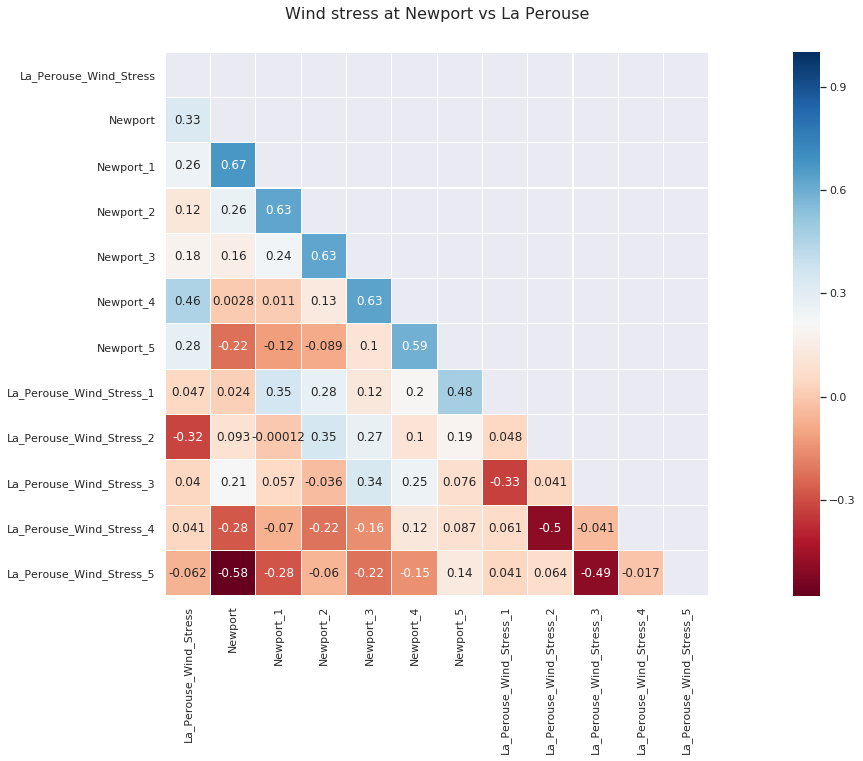

In [63]:
range = pd.date_range('2013-08-01T00:38', '2013-08-31T22:38', freq='60min')


df = pd.DataFrame(index = range)

df['La_Perouse_Wind_Stress'] = La_perouse_stress_daily

daily_wind_stress = pd.DataFrame()

daily_wind_stress['La_Perouse_Wind_Stress'] = La_perouse_stress_daily
# daily_wind_stress['La Perouse'] = df.La_Perouse_Wind_Stress.resample('D').mean()
daily_wind_stress['Newport'] = wind_stress_newport[211:-121]

NON_DER = mydates_Newport[211:-121]
df_new = df_derived_by_shift(daily_wind_stress, 5, NON_DER)

colormap = plt.cm.RdBu



plt.figure(figsize=(30,10))
plt.title(u'Wind stress at Newport vs La Perouse', y=1.05, size=16)

mask = np.zeros_like(df_new.corr())
mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(df_new.corr(), mask=mask, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)



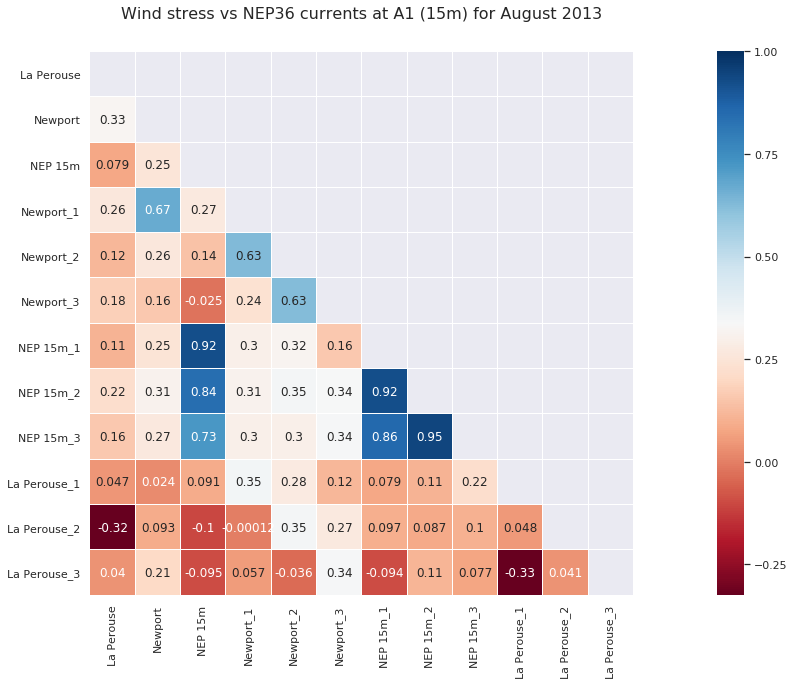

In [73]:


range = pd.date_range('2013-08-01', '2013-08-31', freq='D')


wind_stress_adcp_corr = pd.DataFrame(index = range)
wind_stress_adcp_corr['La Perouse'] = La_perouse_stress_daily
wind_stress_adcp_corr['Newport'] = wind_stress_newport[211:-121]
wind_stress_adcp_corr['NEP 15m'] = v_unrotated[94:-55,10,j,i]

NON_DER = mydates_Newport[211:-121]
df_new = df_derived_by_shift(wind_stress_adcp_corr, 3, NON_DER)

colormap = plt.cm.RdBu



plt.figure(figsize=(30,10))
plt.title(u'Wind stress vs NEP36 currents at A1 (15m) for August 2013', y=1.05, size=16)

mask = np.zeros_like(df_new.corr())
mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(df_new.corr(), mask=mask, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)


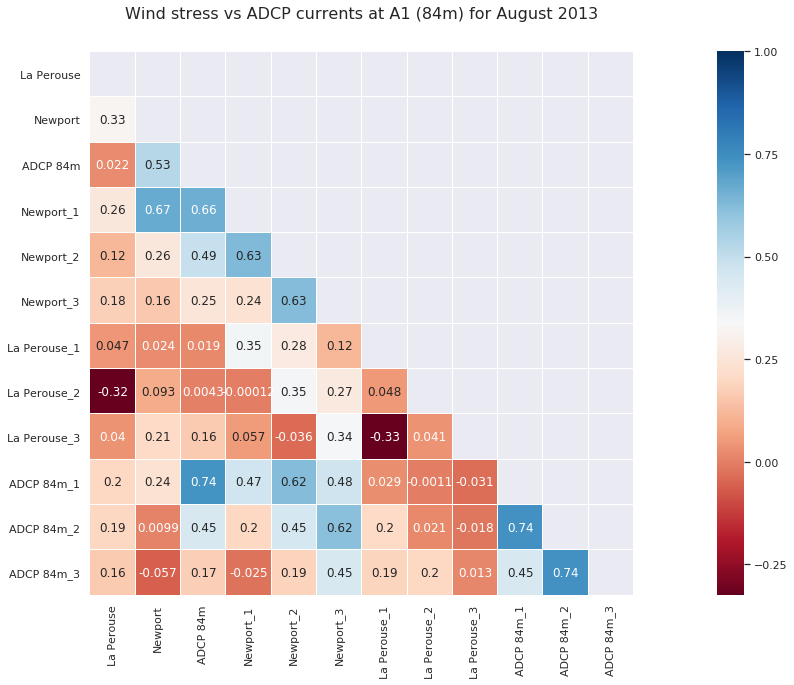

In [79]:
range = pd.date_range('2013-08-01', '2013-08-31', freq='D')


wind_stress_adcp_corr = pd.DataFrame(index = range)
wind_stress_adcp_corr['La Perouse'] = La_perouse_stress_daily
wind_stress_adcp_corr['Newport'] = wind_stress_newport[211:-121]
wind_stress_adcp_corr['ADCP 84m'] = north_84


NON_DER = mydates_Newport[211:-121]
df_new = df_derived_by_shift(wind_stress_adcp_corr, 3, NON_DER)


plt.figure(figsize=(30,10))
plt.title(u'Wind stress vs ADCP currents at A1 (84m) for August 2013', y=1.05, size=16)

mask = np.zeros_like(df_new.corr())
mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(df_new.corr(), mask=mask, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

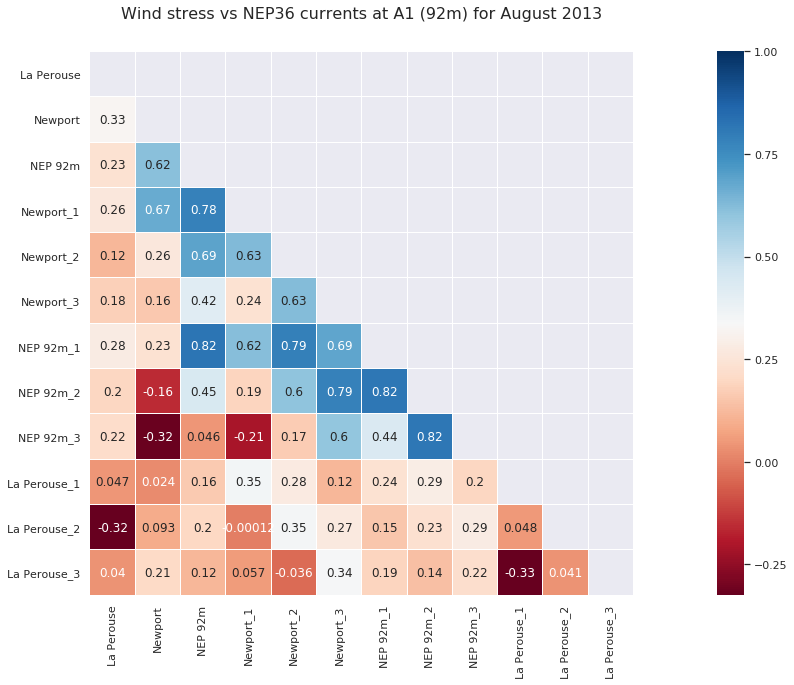

In [83]:
range = pd.date_range('2013-08-01', '2013-08-31', freq='D')


wind_stress_adcp_corr = pd.DataFrame(index = range)
wind_stress_adcp_corr['La Perouse'] = La_perouse_stress_daily
wind_stress_adcp_corr['Newport'] = wind_stress_newport[211:-121]
wind_stress_adcp_corr['NEP 92m'] = v_unrotated[94:-55,22,j,i]

NON_DER = mydates_Newport[211:-121]
df_new = df_derived_by_shift(wind_stress_adcp_corr, 3, NON_DER)

colormap = plt.cm.RdBu



plt.figure(figsize=(30,10))
plt.title(u'Wind stress vs NEP36 currents at A1 (92m) for August 2013', y=1.05, size=16)

mask = np.zeros_like(df_new.corr())
mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(df_new.corr(), mask=mask, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

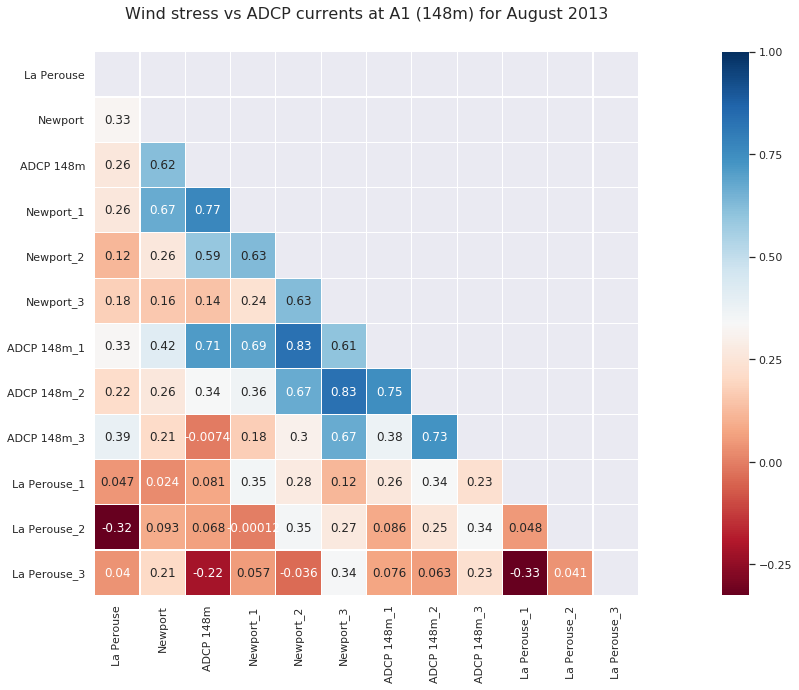

In [75]:
range = pd.date_range('2013-08-01', '2013-08-31', freq='D')


wind_stress_adcp_corr = pd.DataFrame(index = range)
wind_stress_adcp_corr['La Perouse'] = La_perouse_stress_daily
wind_stress_adcp_corr['Newport'] = wind_stress_newport[211:-121]
wind_stress_adcp_corr['ADCP 148m'] = north_148


NON_DER = mydates_Newport[211:-121]
df_new = df_derived_by_shift(wind_stress_adcp_corr, 3, NON_DER)


plt.figure(figsize=(30,10))
plt.title(u'Wind stress vs ADCP currents at A1 (148m) for August 2013', y=1.05, size=16)

mask = np.zeros_like(df_new.corr())
mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(df_new.corr(), mask=mask, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

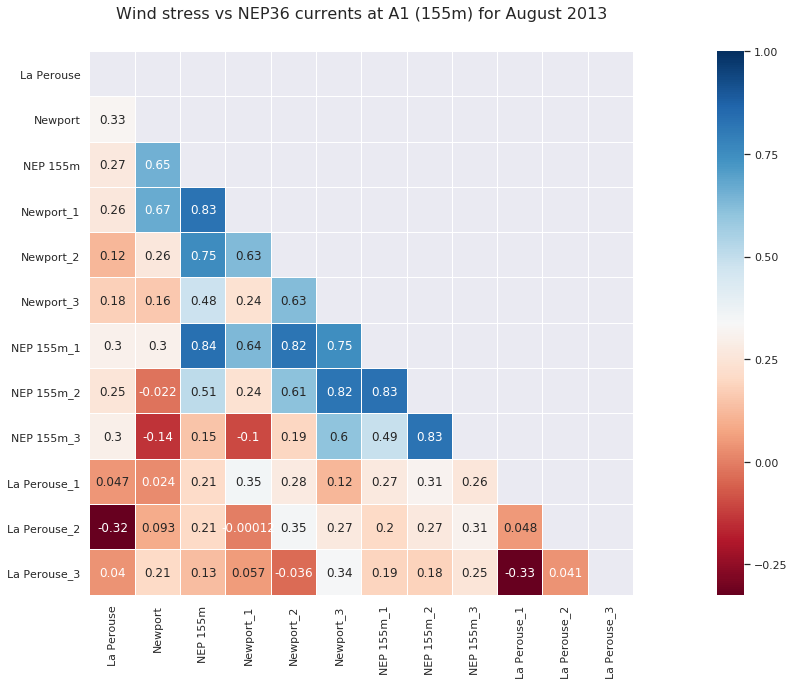

In [78]:
range = pd.date_range('2013-08-01', '2013-08-31', freq='D')


wind_stress_adcp_corr = pd.DataFrame(index = range)
wind_stress_adcp_corr['La Perouse'] = La_perouse_stress_daily
wind_stress_adcp_corr['Newport'] = wind_stress_newport[211:-121]
wind_stress_adcp_corr['NEP 155m'] = v_unrotated[94:-55,24,j,i]

NON_DER = mydates_Newport[211:-121]
df_new = df_derived_by_shift(wind_stress_adcp_corr, 3, NON_DER)

colormap = plt.cm.RdBu



plt.figure(figsize=(30,10))
plt.title(u'Wind stress vs NEP36 currents at A1 (155m) for August 2013', y=1.05, size=16)

mask = np.zeros_like(df_new.corr())
mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(df_new.corr(), mask=mask, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

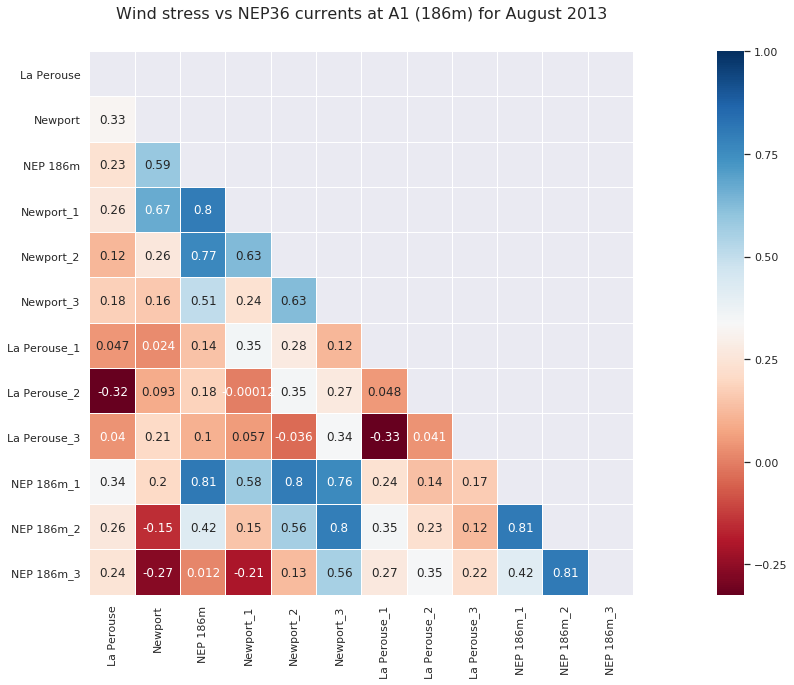

In [74]:
range = pd.date_range('2013-08-01', '2013-08-31', freq='D')


wind_stress_adcp_corr = pd.DataFrame(index = range)
wind_stress_adcp_corr['La Perouse'] = La_perouse_stress_daily
wind_stress_adcp_corr['Newport'] = wind_stress_newport[211:-121]
wind_stress_adcp_corr['NEP 186m'] = v_unrotated[94:-55,25,j,i]

NON_DER = mydates_Newport[211:-121]
df_new = df_derived_by_shift(wind_stress_adcp_corr, 3, NON_DER)

colormap = plt.cm.RdBu



plt.figure(figsize=(30,10))
plt.title(u'Wind stress vs NEP36 currents at A1 (186m) for August 2013', y=1.05, size=16)

mask = np.zeros_like(df_new.corr())
mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(df_new.corr(), mask=mask, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

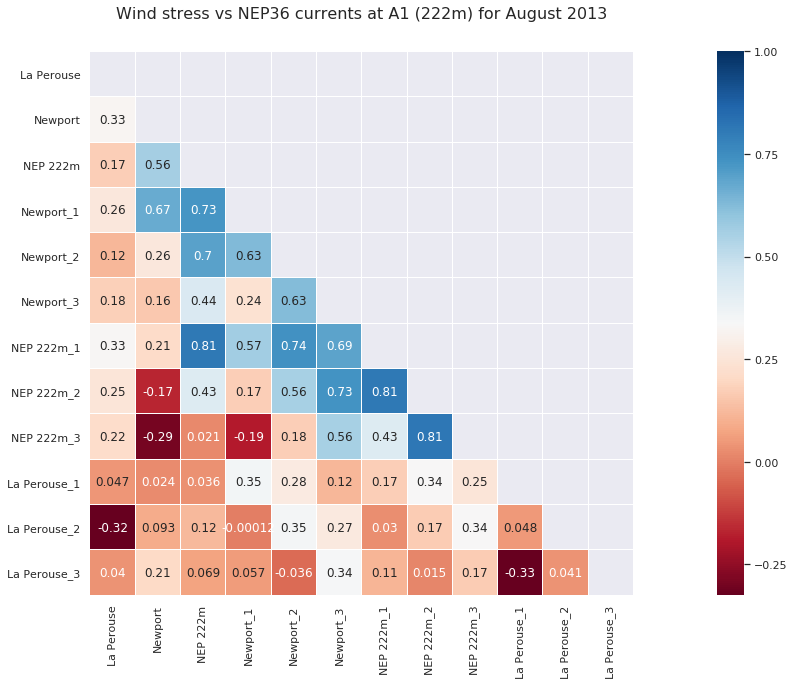

In [86]:
range = pd.date_range('2013-08-01', '2013-08-31', freq='D')


wind_stress_adcp_corr = pd.DataFrame(index = range)
wind_stress_adcp_corr['La Perouse'] = La_perouse_stress_daily
wind_stress_adcp_corr['Newport'] = wind_stress_newport[211:-121]
wind_stress_adcp_corr['NEP 222m'] = v_unrotated[94:-55,26,j,i]

NON_DER = mydates_Newport[211:-121]
df_new = df_derived_by_shift(wind_stress_adcp_corr, 3, NON_DER)

colormap = plt.cm.RdBu



plt.figure(figsize=(30,10))
plt.title(u'Wind stress vs NEP36 currents at A1 (222m) for August 2013', y=1.05, size=16)

mask = np.zeros_like(df_new.corr())
mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(df_new.corr(), mask=mask, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

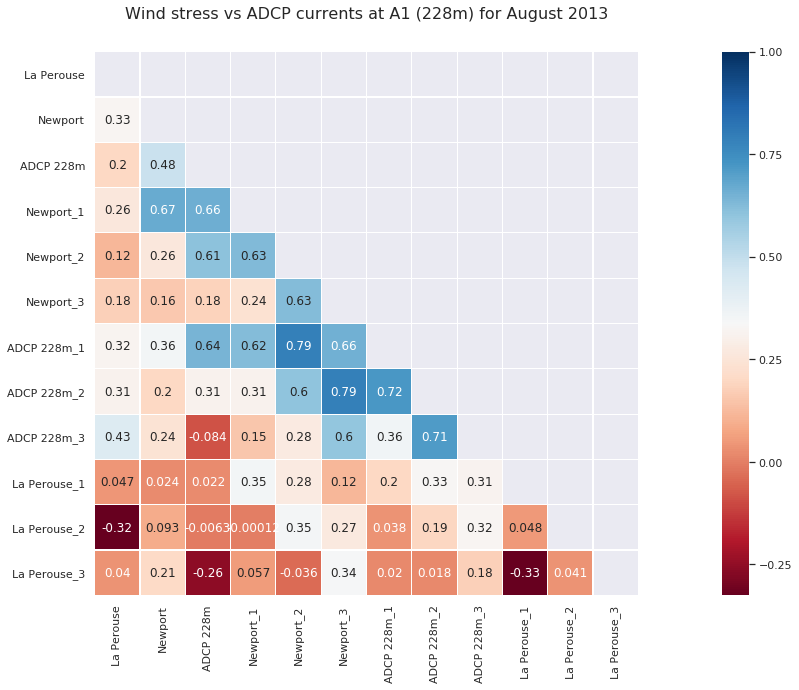

In [87]:
range = pd.date_range('2013-08-01', '2013-08-31', freq='D')


wind_stress_adcp_corr = pd.DataFrame(index = range)
wind_stress_adcp_corr['La Perouse'] = La_perouse_stress_daily
wind_stress_adcp_corr['Newport'] = wind_stress_newport[211:-121]
wind_stress_adcp_corr['ADCP 228m'] = north_228


NON_DER = mydates_Newport[211:-121]
df_new = df_derived_by_shift(wind_stress_adcp_corr, 3, NON_DER)


plt.figure(figsize=(30,10))
plt.title(u'Wind stress vs ADCP currents at A1 (228m) for August 2013', y=1.05, size=16)

mask = np.zeros_like(df_new.corr())
mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(df_new.corr(), mask=mask, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

## Points:

### The winds at Newport determine the currents at A1

#### 1) The ADCP at 84m has a much better correlation with the wind stress at Newport as compared with the model at 15m (r = 0.66 vs 0.27)

#### 2) The Newport wind stress is nicely correlated with the NEP currents at 186m (r = 0.8 to 0.81) and ADCP at 148m (r = 0.77 to 0.83)

#### 3)  The same can be said for ADCP at 196 m (r = 0.66 to 0.78)

#### 4) The same can be said for ADCP at 228m (r = 0.66 to 0.79) and NEP36 at 222m (r = 0.73 to 0.81).

#### 4) It is hard to see correlation with surface currents (both local winds at La Perouse and remote winds at Newport). The surface currents are steady (southward bound) eddy field not actively affecting the flow. 

#### 5) The deeper currents are well correlated with the Newport winds; wave coming from south or undercurrent being wind correlated ?? 

In [24]:
def U_timeseries_at_WCVI_locations(grid_U):
    
    u_vel = grid_U.variables['uo'][:,:,:,:]

    
    vector_u = namedtuple('vector_u', 'u_vel')

    return vector_u(u_vel)


def V_timeseries_at_WCVI_locations(grid_V):
    
    v_vel = grid_V.variables['vo'][:,:,:,:]

    
    vector_v = namedtuple('vector_v', 'v_vel')

    return vector_v(v_vel)




def uv_wind_timeseries_at_point(grid_weather, j, i, datetimes=False):
    """Return the u and v wind components and time counter values
    at a single grid point from a weather forcing dataset.

    :arg grid_weather: Weather forcing dataset, typically from an
                       :file:`ops_yYYYYmMMdDD.nc` file produced by the
                       :py:mod:`nowcast.workers.grid_to_netcdf` worker.
    :type grid_weather: :py:class:`netCDF4.Dataset`

    :arg int j: j-direction (longitude) index of grid point to get wind
                components at.

    :arg int i: i-direction (latitude) index of grid point to get wind
                components at.

    :arg boolean datetimes: Return time counter values as
                            :py:class:`datetime.datetime` objects if
                            :py:obj:`True`, otherwise return them as
                            :py:class:`arrow.Arrow` objects (the default).

    :returns: 2-tuple of 1-dimensional :py:class:`numpy.ndarray` objects,
              The :py:attr:`u` attribute holds the u-direction wind
              component,
              The :py:attr:`v` attribute holds the v-direction wind
              component,
              and the :py:attr:`time` attribute holds the time counter
              values.
    :rtype: :py:class:`collections.namedtuple`
    """
    u_wind = grid_weather.variables['u_wind'][:, j, i]
    v_wind = grid_weather.variables['v_wind'][:, j, i]
    time = timestamp(grid_weather, range(len(u_wind)))
    if datetimes:
        time = np.array([a.datetime for a in time])
    wind_ts = namedtuple('wind_ts', 'u, v, time')

    return wind_ts(u_wind, v_wind, np.array(time))

def timestamp(dataset, tindex, time_var='time_counter'):
    """Return the time stamp of the tindex time_counter value(s) in dataset.

    The time stamp is calculated by adding the time_counter[tindex] value
    (in seconds) to the dataset's time_counter.time_origin value.

    :arg dataset: netcdf dataset object
    :type dataset: :py:class:`netCDF4.Dataset`

    :arg tindex: time_counter variable index.
    :type tindex: int or iterable

    :arg time_var: name of the time variable
    :type time_var: str

    :returns: Time stamp value(s) at tindex in the dataset.
    :rtype: :py:class:`Arrow` instance or list of instances
    """
    time_orig = time_origin(dataset, time_var=time_var)
    time_counter = dataset.variables[time_var]
    try:
        iter(tindex)
    except TypeError:
        tindex = [tindex]
    results = []
    for i in tindex:
        try:
            results.append(time_orig + timedelta(seconds=time_counter[i]))
        except IndexError:
            raise IndexError(
                'time_counter variable has no tindex={}'.format(tindex))
    if len(results) > 1:
        return results
    else:

        return results[0]

def time_origin(dataset, time_var='time_counter'):
    """Return the time_var.time_origin value.

    :arg dataset: netcdf dataset object
    :type dataset: :py:class:`netCDF4.Dataset` or :py:class:`xarray.Dataset`

    :arg time_var: name of time variable
    :type time_var: str

    :returns: Value of the time_origin attribute of the time_counter
              variable.
    :rtype: :py:class:`Arrow` instance
    """
    try:
        time_counter = dataset.variables[time_var]
    except KeyError:
        raise KeyError(
            'dataset does not have {time_var} variable'.format(
                time_var=time_var))
    try:
        # netCDF4 dataset
        time_orig = time_counter.time_origin.title()
    except AttributeError:
        try:
            # xarray dataset
            time_orig = time_counter.attrs['time_origin'].title()
        except KeyError:
            raise AttributeError(
                'NetCDF: '
                '{time_var} variable does not have '
                'time_origin attribute'.format(time_var=time_var))
    value = arrow.get(
        time_orig,
        ['YYYY-MMM-DD HH:mm:ss',
         'DD-MMM-YYYY HH:mm:ss',
         'YYYY-MM-DD HH:mm:ss'])

    return value

import numpy

def smooth(x,window_len=24,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise "Input vector needs to be bigger than window size."


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"


    s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s, mode='same')
    
    return y[window_len - 1:-window_len + 1]



In [25]:
from __future__ import division
import glob
import os
import fnmatch
from collections import namedtuple, OrderedDict

import os

zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht'][:32]
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))

u_vel = np.empty((180,zlevels.shape[0],y_wcvi_slice.shape[0]+1,x_wcvi_slice.shape[0]+1))
v_vel = np.empty((180,zlevels.shape[0],y_wcvi_slice.shape[0]+1,x_wcvi_slice.shape[0]+1))



i = 0

for file in sorted(glob.glob('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d*grid_U*.nc')):
    vector_u = U_timeseries_at_WCVI_locations(nc.Dataset(file))
    u_vel[i:i+10,...] = vector_u[0]
    i = i+10

j = 0
for file in sorted(glob.glob('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d*grid_V*.nc')):
    vector_v = V_timeseries_at_WCVI_locations(nc.Dataset(file))
    v_vel[j:j+10,...] = vector_v[0]
    j = j+10
    
    
u_tzyx, v_tzyx = viz_tools.unstagger(u_vel, v_vel)

mag_vel = np.sqrt(np.multiply(u_tzyx,u_tzyx) +  np.multiply(v_tzyx,v_tzyx));
ang_vel = np.degrees(np.arctan2(v_tzyx, u_tzyx))

u_unrotated = u_tzyx
v_unrotated = v_tzyx



In [26]:

file_model = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_T_20130429-20130508.nc')

lon = file_model.variables['nav_lon'][1:,1:]
lat = file_model.variables['nav_lat'][1:,1:]

In [27]:

lon_A1 = -126.20433
lat_A1 = 48.52958

j, i = geo_tools.find_closest_model_point(lon_A1,lat_A1,\
                                          lon,lat,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 


print(j,i)


89 92


In [28]:
date1 = '2013-04-29'
date2 = '2013-10-25'
mydates = pd.date_range(date1, date2, freq= 'D')

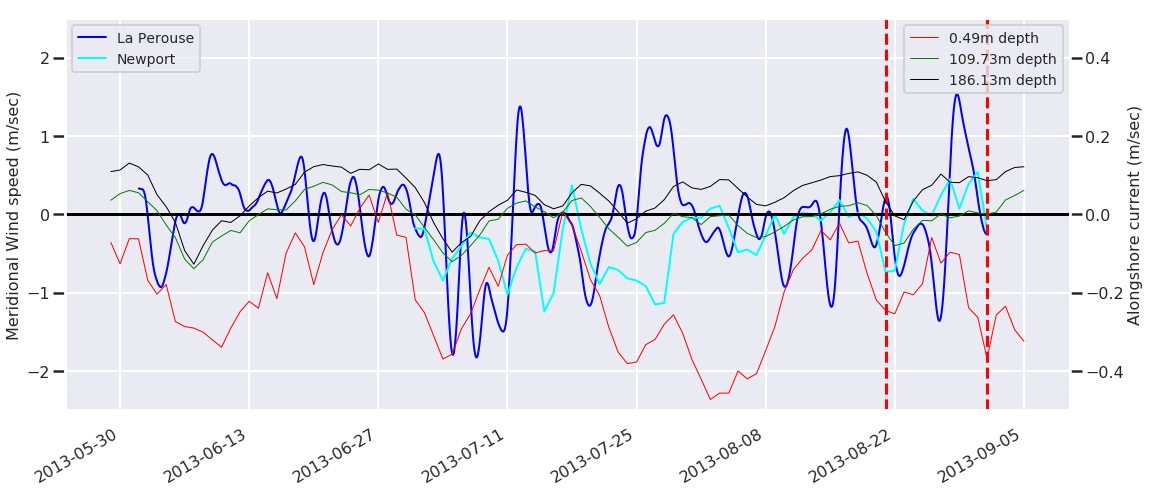

In [92]:

step = 1
window_size_1 = 72



time_axis = datetime_2013[::step]






s_v = v_wind[::step]   
filt_v = smooth(s_v,window_size_1,'hanning')

s_u = u_wind[::step]   
filt_u = smooth(s_u,window_size_1,'hanning')

s_wind = wind_spd[::step]
filt_wind = smooth(s_wind,window_size_1,'hanning')




fig, ax1 = plt.subplots(1, 1, figsize=(18,8))

ax1.plot(time_axis ,filt_v[::step], 'b-',linewidth=2, label = 'La Perouse')

ax1.plot(mydates_Newport[181:-121], wind_stress_newport[180:-120]*(10^3), c = 'cyan', linewidth=2, label = 'Newport')
# ax1.plot(time_axis_orford ,filt_v_orford[::step], 'cyan',linewidth=2)


# ax1.legend(['Filtered'])
# ax1.set_title("Meridional Wind speed", fontsize = 16)
ax1.axhline(y=0, color = 'k')
ax1.axvline(x = time_axis[1944], color = 'r', linestyle  = '--')
ax1.axvline(x = time_axis[-1], color = 'r', linestyle  = '--')
ax1.tick_params(axis='both',labelsize =16)
ax1.set_ylim(-2.5,2.5)
ax1.set_ylabel('Meridional Wind speed (m/sec)', fontsize = 16)# and Wind stress (*10^3) (N/m^2)', fontsize = 16)
ax1.grid()
ax1.legend(loc='best', fontsize = 14)

ax2 = ax1.twinx()
ax2.plot(mydates[30:-50], v_unrotated[30:-50,0,j,i], 'r', linewidth=1, label = '{0:0.2f}m depth'.format(zlevels[0]))
ax2.plot(mydates[30:-50], v_unrotated[30:-50,22,j,i], 'g', linewidth=1, label = '{0:0.2f}m depth'.format(zlevels[22]))
ax2.plot(mydates[30:-50], v_unrotated[30:-50,25,j,i], 'k', linewidth=1, label = '{0:0.2f}m depth'.format(zlevels[25]))

# ax3 = ax1.twinx()
# ax1.plot(mydates_Newport[1:-1], wind_stress_newport[:])#, 'golden', linewidth=2, label = 'Newport')
# ax3.set_yticklabels([])

ax2.set_ylabel('Alongshore current (m/sec)', fontsize = 16)
ax2.set_ylim(-0.5, 0.5)
ax2.tick_params(axis='both',labelsize =16)
ax2.legend(loc = 'best', fontsize  =14)



# offset = 60
# new_fixed_axis = ax2.get_grid_helper().new_fixed_axis
# ax2.axis["right"] = new_fixed_axis(loc="right",
#                                     axes=ax2,
#                                     offset=(offset, 0))

fig.autofmt_xdate()



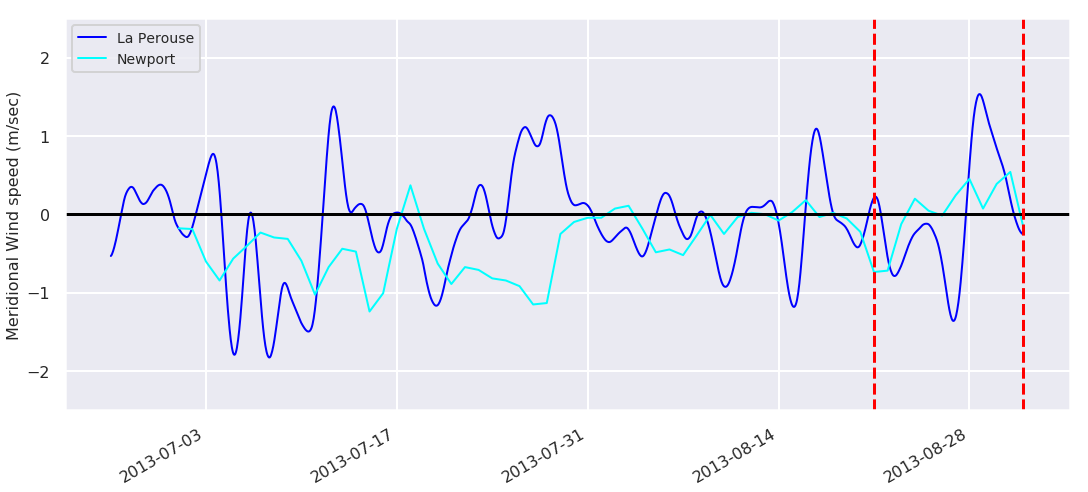

In [88]:

step = 1
window_size_1 = 72



time_axis = datetime_2013[::step]






s_v = v_wind[::step]   
filt_v = smooth(s_v,window_size_1,'hanning')

s_u = u_wind[::step]   
filt_u = smooth(s_u,window_size_1,'hanning')

s_wind = wind_spd[::step]
filt_wind = smooth(s_wind,window_size_1,'hanning')




fig, ax1 = plt.subplots(1, 1, figsize=(18,8))

ax1.plot(time_axis[600:] ,filt_v[600:], 'b-',linewidth=2, label = 'La Perouse')

ax1.plot(mydates_Newport[181:-121], wind_stress_newport[180:-120]*(10^3), c = 'cyan', linewidth=2, label = 'Newport')
# ax1.plot(time_axis_orford ,filt_v_orford[::step], 'cyan',linewidth=2)


# ax1.legend(['Filtered'])
# ax1.set_title("Meridional Wind speed", fontsize = 16)
ax1.axhline(y=0, color = 'k')
ax1.axvline(x = time_axis[1944], color = 'r', linestyle  = '--')
ax1.axvline(x = time_axis[-1], color = 'r', linestyle  = '--')
ax1.tick_params(axis='both',labelsize =16)
ax1.set_ylim(-2.5,2.5)
ax1.set_ylabel('Meridional Wind speed (m/sec)', fontsize = 16)# and Wind stress (*10^3) (N/m^2)', fontsize = 16)
ax1.grid()
ax1.legend(loc='best', fontsize = 14)

# ax2 = ax1.twinx()
# ax2.plot(mydates[30:-50], v_unrotated[30:-50,0,j,i], 'r', linewidth=1, label = '{0:0.2f}m depth'.format(zlevels[0]))
# ax2.plot(mydates[30:-50], v_unrotated[30:-50,22,j,i], 'g', linewidth=1, label = '{0:0.2f}m depth'.format(zlevels[22]))
# ax2.plot(mydates[30:-50], v_unrotated[30:-50,25,j,i], 'k', linewidth=1, label = '{0:0.2f}m depth'.format(zlevels[25]))

# ax3 = ax1.twinx()
# ax1.plot(mydates_Newport[1:-1], wind_stress_newport[:])#, 'golden', linewidth=2, label = 'Newport')
# ax3.set_yticklabels([])

# ax2.set_ylabel('Alongshore current (m/sec)', fontsize = 16)
# ax2.set_ylim(-0.5, 0.5)
# ax2.tick_params(axis='both',labelsize =16)
# ax2.legend(loc = 'best', fontsize  =14)



# offset = 60
# new_fixed_axis = ax2.get_grid_helper().new_fixed_axis
# ax2.axis["right"] = new_fixed_axis(loc="right",
#                                     axes=ax2,
#                                     offset=(offset, 0))

fig.autofmt_xdate()



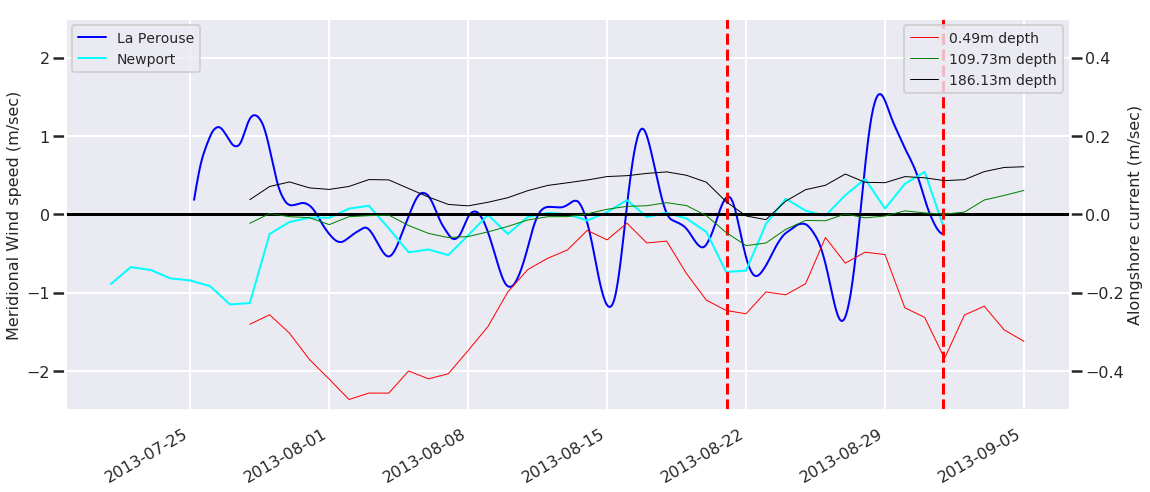

In [97]:

step = 1
window_size_1 = 72



time_axis = datetime_2013[::step]






s_v = v_wind[::step]   
filt_v = smooth(s_v,window_size_1,'hanning')

s_u = u_wind[::step]   
filt_u = smooth(s_u,window_size_1,'hanning')

s_wind = wind_spd[::step]
filt_wind = smooth(s_wind,window_size_1,'hanning')




fig, ax1 = plt.subplots(1, 1, figsize=(18,8))

ax1.plot(time_axis[1300:] ,filt_v[1300:], 'b-',linewidth=2, label = 'La Perouse')

ax1.plot(mydates_Newport[201:-121], wind_stress_newport[200:-120]*(10^3), c = 'cyan', linewidth=2, label = 'Newport')
# ax1.plot(time_axis_orford ,filt_v_orford[::step], 'cyan',linewidth=2)


# ax1.legend(['Filtered'])
# ax1.set_title("Meridional Wind speed", fontsize = 16)
ax1.axhline(y=0, color = 'k')
ax1.axvline(x = time_axis[1944], color = 'r', linestyle  = '--')
ax1.axvline(x = time_axis[-1], color = 'r', linestyle  = '--')
ax1.tick_params(axis='both',labelsize =16)
ax1.set_ylim(-2.5,2.5)
ax1.set_ylabel('Meridional Wind speed (m/sec)', fontsize = 16)# and Wind stress (*10^3) (N/m^2)', fontsize = 16)
ax1.grid()
ax1.legend(loc='best', fontsize = 14)

ax2 = ax1.twinx()
ax2.plot(mydates[90:-50], v_unrotated[90:-50,0,j,i], 'r', linewidth=1, label = '{0:0.2f}m depth'.format(zlevels[0]))
ax2.plot(mydates[90:-50], v_unrotated[90:-50,22,j,i], 'g', linewidth=1, label = '{0:0.2f}m depth'.format(zlevels[22]))
ax2.plot(mydates[90:-50], v_unrotated[90:-50,25,j,i], 'k', linewidth=1, label = '{0:0.2f}m depth'.format(zlevels[25]))

# ax3 = ax1.twinx()
# ax1.plot(mydates_Newport[1:-1], wind_stress_newport[:])#, 'golden', linewidth=2, label = 'Newport')
# ax3.set_yticklabels([])

ax2.set_ylabel('Alongshore current (m/sec)', fontsize = 16)
ax2.set_ylim(-0.5, 0.5)
ax2.tick_params(axis='both',labelsize =16)
ax2.legend(loc = 'best', fontsize  =14)



# offset = 60
# new_fixed_axis = ax2.get_grid_helper().new_fixed_axis
# ax2.axis["right"] = new_fixed_axis(loc="right",
#                                     axes=ax2,
#                                     offset=(offset, 0))

fig.autofmt_xdate()



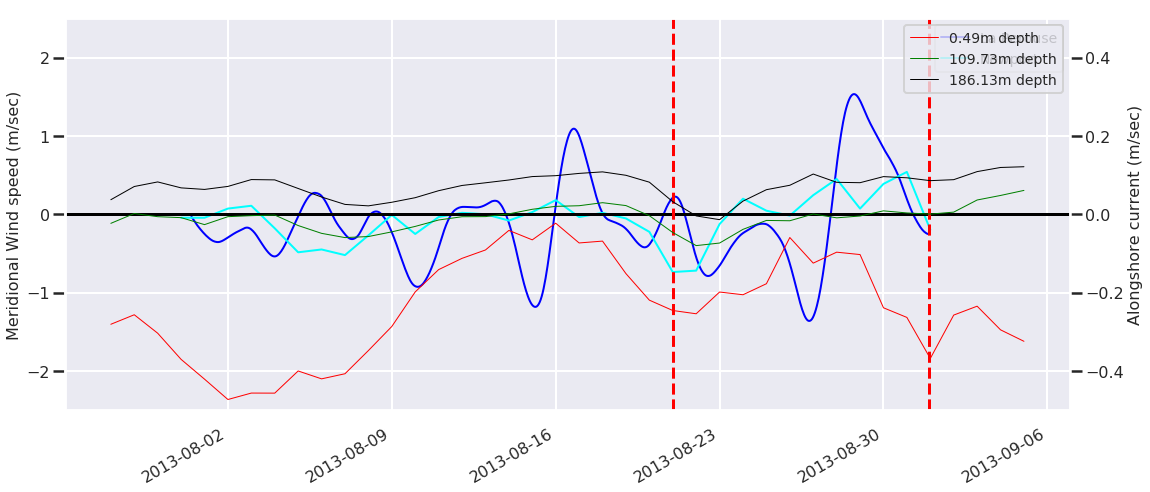

In [82]:

step = 1
window_size_1 = 72



time_axis = datetime_2013[::step]






s_v = v_wind[::step]   
filt_v = smooth(s_v,window_size_1,'hanning')

s_u = u_wind[::step]   
filt_u = smooth(s_u,window_size_1,'hanning')

s_wind = wind_spd[::step]
filt_wind = smooth(s_wind,window_size_1,'hanning')




fig, ax1 = plt.subplots(1, 1, figsize=(18,8))

ax1.plot(time_axis[1450:] ,filt_v[1450:], 'b-',linewidth=2, label = 'La Perouse')

ax1.plot(mydates_Newport[211:-121], wind_stress_newport[210:-120]*(10^3), c = 'cyan', linewidth=2, label = 'Newport')
# ax1.plot(time_axis_orford ,filt_v_orford[::step], 'cyan',linewidth=2)


# ax1.legend(['Filtered'])
# ax1.set_title("Meridional Wind speed", fontsize = 16)
ax1.axhline(y=0, color = 'k')
ax1.axvline(x = time_axis[1944], color = 'r', linestyle  = '--')
ax1.axvline(x = time_axis[-1], color = 'r', linestyle  = '--')
ax1.tick_params(axis='both',labelsize =16)
ax1.set_ylim(-2.5,2.5)
ax1.set_ylabel('Meridional Wind speed (m/sec)', fontsize = 16)# and Wind stress (*10^3) (N/m^2)', fontsize = 16)
ax1.grid()
ax1.legend(loc='best', fontsize = 14)

ax2 = ax1.twinx()
ax2.plot(mydates[90:-50], v_unrotated[90:-50,0,j,i], 'r', linewidth=1, label = '{0:0.2f}m depth'.format(zlevels[0]))
ax2.plot(mydates[90:-50], v_unrotated[90:-50,22,j,i], 'g', linewidth=1, label = '{0:0.2f}m depth'.format(zlevels[22]))
ax2.plot(mydates[90:-50], v_unrotated[90:-50,25,j,i], 'k', linewidth=1, label = '{0:0.2f}m depth'.format(zlevels[25]))

# ax3 = ax1.twinx()
# ax1.plot(mydates_Newport[1:-1], wind_stress_newport[:])#, 'golden', linewidth=2, label = 'Newport')
# ax3.set_yticklabels([])

ax2.set_ylabel('Alongshore current (m/sec)', fontsize = 16)
ax2.set_ylim(-0.5, 0.5)
ax2.tick_params(axis='both',labelsize =16)
ax2.legend(loc = 'best', fontsize  =14)

# offset = 60
# new_fixed_axis = ax2.get_grid_helper().new_fixed_axis
# ax2.axis["right"] = new_fixed_axis(loc="right",
#                                     axes=ax2,
#                                     offset=(offset, 0))

fig.autofmt_xdate()



In [ ]:
df = pd.DataFrame()
df['Newport_Wind_stress']

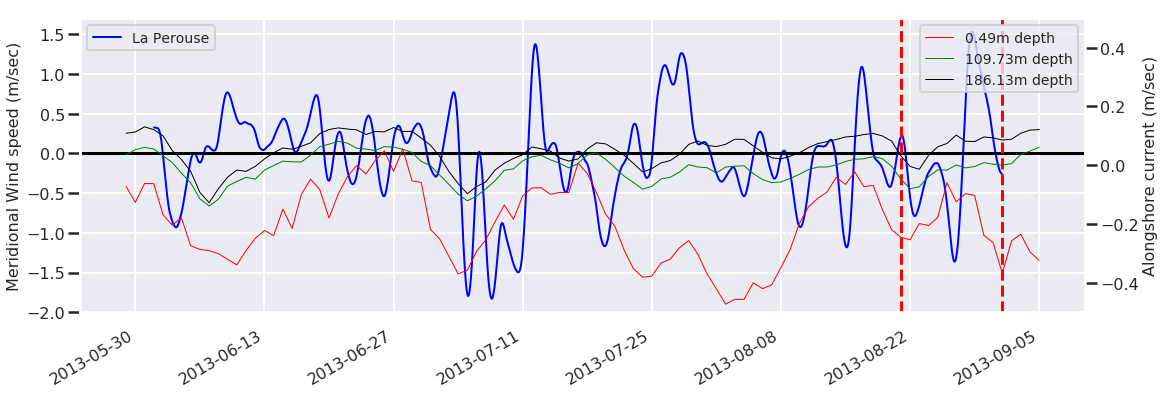

In [47]:

step = 1
window_size_1 = 72



time_axis = datetime_2013[::step]






s_v = v_wind[::step]   
filt_v = smooth(s_v,window_size_1,'hanning')

s_u = u_wind[::step]   
filt_u = smooth(s_u,window_size_1,'hanning')

s_wind = wind_spd[::step]
filt_wind = smooth(s_wind,window_size_1,'hanning')




fig, ax1 = plt.subplots(1, 1, figsize=(18,6))

# ax1.plot(time_axis ,La_perouse_stress[::step]*(10^3), 'b-',linewidth=2, label = 'La Perouse')
ax1.plot(time_axisfil ,filt_v[::step], 'b-',linewidth=2, label = 'La Perouse')

# ax1.plot(time_axis_orford ,filt_v_orford[::step], 'cyan',linewidth=2)


# ax1.legend(['Filtered'])
# ax1.set_title("Meridional Wind speed", fontsize = 16)
ax1.axhline(y=0, color = 'k')
ax1.axvline(x = time_axis[1944], color = 'r', linestyle  = '--')
ax1.axvline(x = time_axis[-1], color = 'r', linestyle  = '--')
ax1.tick_params(axis='both',labelsize =16)
# ax1.set_ylim(-2.5,2.5)
ax1.set_ylabel('Meridional Wind speed (m/sec)', fontsize = 16)
ax1.grid()
ax1.legend(loc='best', fontsize = 14)

ax2 = ax1.twinx()
ax2.plot(mydates[30:-50], v_unrotated[30:-50,0,j,i], 'r', linewidth=1, label = '{0:0.2f}m depth'.format(zlevels[0]))
ax2.plot(mydates[30:-50], v_unrotated[30:-50,22,j,i], 'g', linewidth=1, label = '{0:0.2f}m depth'.format(zlevels[22]))
ax2.plot(mydates[30:-50], v_unrotated[30:-50,25,j,i], 'k', linewidth=1, label = '{0:0.2f}m depth'.format(zlevels[25]))

# ax3 = ax1.twinx()
# ax1.plot(mydates_Newport[1:-1], wind_stress_newport[:])#, 'golden', linewidth=2, label = 'Newport')
# ax3.set_yticklabels([])

ax2.set_ylabel('Alongshore current (m/sec)', fontsize = 16)
ax2.set_ylim(-0.5, 0.5)
ax2.tick_params(axis='both',labelsize =16)
ax2.legend(loc = 'best', fontsize  =14)



# offset = 60
# new_fixed_axis = ax2.get_grid_helper().new_fixed_axis
# ax2.axis["right"] = new_fixed_axis(loc="right",
#                                     axes=ax2,
#                                     offset=(offset, 0))

fig.autofmt_xdate()



In [10]:
oregon_data = pd.read_table('/data/ssahu/Falkor_2013/winds/station_46089_tillamook_oregon.csv', delim_whitespace=1, parse_dates= True, header = None, skiprows=2)

# a = orford_data[0].str.split(',', expand=True)

# b = orford_data[1].str.split(',', expand=True)

# df_La_Peruse = pd.concat([a, b], axis=1)

df_cut = oregon_data.drop(oregon_data.columns[7:], axis=1)
columns = ['Year','Month','Day','Hour','Min','Wind Direction (deg)','Wind Speed','GDR','GST','GTIME']
effective = columns[:7]
df_cut.columns = effective


df_cut['Year']   = df_cut['Year'].astype(str)
df_cut['Day']    = df_cut['Day'].astype(str)
df_cut['Month']  = df_cut['Month'].astype(str)
df_cut['Hour']   = df_cut["Hour"].astype(str)

df_cut.columns = df_cut.columns.str.replace(' ', '')



df_cut['Datetime'] = df_cut['Year'] + "-" + df_cut['Month'] + "-" + df_cut['Day']+ " " + df_cut["Hour"] + ":00:00"

df_cut["Datetime"] = pd.to_datetime(df_cut["Datetime"])


df_cut = df_cut.iloc[:,4:]

df_cut = df_cut.set_index(pd.DatetimeIndex(df_cut["Datetime"]))


# df_cut.tail(10)

df_subset = df_cut.loc['2013-06-01 00:00:00':'2013-09-01 00:00:00']

df_subset = df_subset.resample('60T').mean().reset_index()

df_subset.head(10)

Datetime   Min  WindDirection(deg)  WindSpeed
0 2013-06-01 00:00:00  50.0                17.0        1.0
1 2013-06-01 01:00:00  50.0                18.0        1.0
2 2013-06-01 02:00:00  50.0                 5.0        1.4
3 2013-06-01 03:00:00  50.0                23.0        1.1
4 2013-06-01 04:00:00  50.0               317.0        0.6
5 2013-06-01 05:00:00  50.0               286.0        1.3
6 2013-06-01 06:00:00  50.0               238.0        0.9
7 2013-06-01 07:00:00  50.0               191.0        0.6
8 2013-06-01 08:00:00  50.0               186.0        1.5
9 2013-06-01 09:00:00  50.0               177.0        2.3

In [106]:
wind_spd_oregon = df_subset["WindSpeed"].astype(np.float)

wind_dir_oregon = df_subset["WindDirection(deg)"].astype(np.float)

v_wind_oregon = np.empty_like(wind_dir_oregon)

# for i in np.arange(wind_dir_orford.shape[0]):
#     v_wind_orford[i] = np.multiply(wind_spd_orford[i],np.sin(wind_dir_orford))
    
    
    

u_wind_oregon = np.multiply(wind_spd_oregon[:],np.cos(wind_dir_oregon[:]))
# u_wind_orford = u_wind_orford.resample('60T').mean()

v_wind_oregon= np.multiply(wind_spd_oregon[:],np.sin(wind_dir_oregon[:]))
# v_wind_orford = v_wind_orford.resample('60T').mean()



time_2013_oregon = df_subset["Datetime"].astype(str)

datetime_2013_oregon = np.empty_like(time_2013_oregon)

for i in np.arange(datetime_2013_oregon.shape[0]):
    datetime_2013_oregon[i] = datetime.strptime(time_2013_oregon[i], '%Y-%m-%d %H:%M:%S')
    
datetime_2013_oregon = datetime_2013_oregon.astype(np.datetime64)

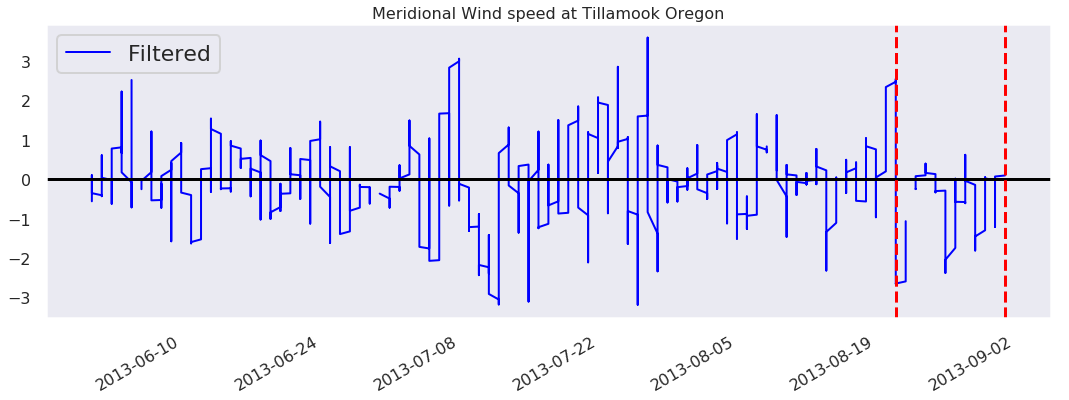

In [14]:

step = 1
window_size_1 = 4
window_size_2 = 24



# time_axis = datetime_2013[::step]

time_axis_oregon = datetime_2013_oregon[::step]





# s_v = v_wind_oregon[::step]   
# filt_v = smooth(s_v,window_size_1,'hanning')

# s_u = u_wind_oregon[::step]   
# filt_u = smooth(s_u,window_size_1,'hanning')

# s_wind = wind_spd_oregon[::step]
# filt_wind = smooth(s_wind,window_size_1,'hanning')



s_v_oregon = v_wind_oregon[::step]   
filt_v_oregon = smooth(s_v_oregon,window_size_2,'hanning')


s_u_oregon = u_wind_oregon[::step]   
filt_u_oregon = smooth(s_u_oregon, window_size_2,'hanning')

s_wind_oregon = wind_spd_oregon[::step]
filt_wind_oregon = smooth(s_wind_oregon,window_size_2,'hanning')

fig,ax1 = plt.subplots(1, 1, figsize=(18,6))

ax1.plot(time_axis_oregon ,filt_v_oregon[::step], 'b-',linewidth=2)
# ax1.plot(time_axis_orford ,filt_v_orford[::step], 'cyan',linewidth=2)


ax1.legend(['Filtered'])
ax1.set_title("Meridional Wind speed at Tillamook Oregon", fontsize = 16)
ax1.axhline(y=0, color = 'k')
ax1.axvline(x = time_axis_oregon[1944], color = 'r', linestyle  = '--')
ax1.axvline(x = time_axis_oregon[-1], color = 'r', linestyle  = '--')
ax1.tick_params(axis='both',labelsize =16)
# ax1.set_ylim(-2.5,2.5)
fig.autofmt_xdate()



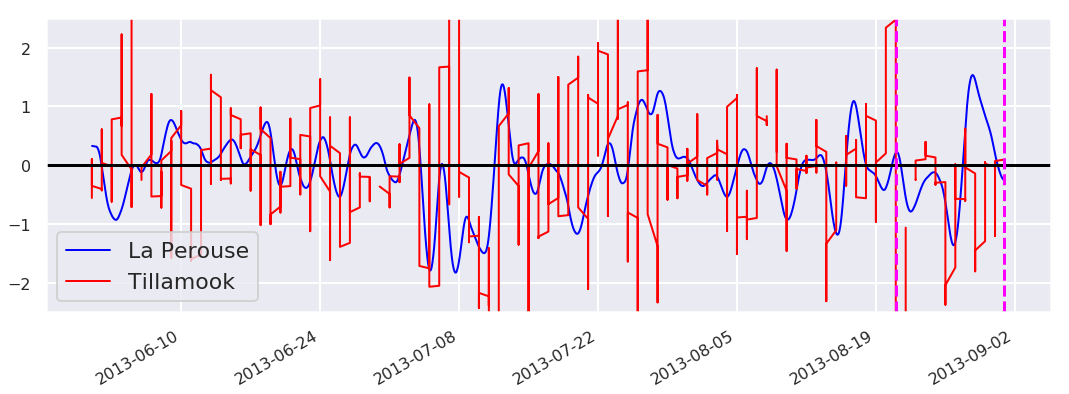

In [16]:

step = 1
window_size_1 = 72



time_axis = datetime_2013[::step]






s_v = v_wind[::step]   
filt_v = smooth(s_v,window_size_1,'hanning')

s_u = u_wind[::step]   
filt_u = smooth(s_u,window_size_1,'hanning')

s_wind = wind_spd[::step]
filt_wind = smooth(s_wind,window_size_1,'hanning')




fig,ax1 = plt.subplots(1, 1, figsize=(18,6))

ax1.plot(time_axis ,filt_v[::step], 'b-',linewidth=2, label = 'La Perouse')
ax1.plot(time_axis_oregon ,filt_v_oregon[::step], 'r-',linewidth=2, label = 'Tillamook')
# ax1.plot(time_axis_orford ,filt_v_orford[::step], 'cyan',linewidth=2)


# ax1.legend(['Filtered'])
# ax1.set_title("Meridional Wind speed at La Perouse", fontsize = 16)
ax1.axhline(y=0, color = 'k')
ax1.axvline(x = time_axis[1944], color = 'magenta', linestyle  = '--')
ax1.axvline(x = time_axis[-1], color = 'magenta', linestyle  = '--')
ax1.tick_params(axis='both',labelsize =16)
ax1.set_ylim(-2.5,2.5)
ax1.grid()
ax1.legend(loc='best')

fig.autofmt_xdate()



In [45]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

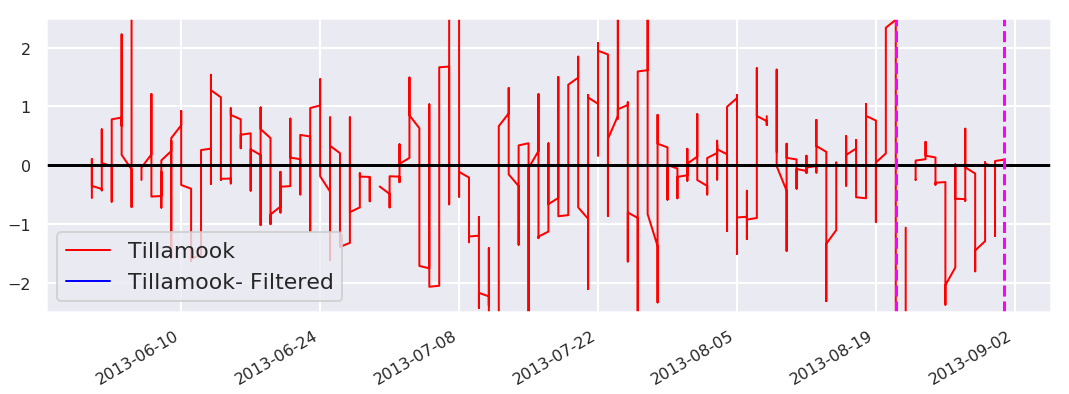

In [46]:
step = 1
order = 4
fs = 1/(3600)      # sample rate, Hz
cutoff = 1/(72*3600)  # desired cutoff frequency of the filter, Hz



from scipy import signal
# b, a = signal.butter(2, 0.01, btype='lowpass', analog=True)
b, a = butter_lowpass(cutoff, fs, order)
# b, a = signal.iirdesign(wp = 0.33, ws= 0.1, gstop= 10, gpass=1, ftype='cheby1')
low_passed_v = signal.filtfilt(b, a, v_wind_oregon[::step])


# low_passed_u = signal.filtfilt(b, a, u_wind_oregon[::step])
# low_passed_mag = signal.filtfilt(b, a, wind_spd_oregon[::step])

fig,ax1 = plt.subplots(1, 1, figsize=(18,6))

# ax1.plot(time_axis ,filt_v[::step], 'b-',linewidth=2, label = 'La Perouse')
ax1.plot(time_axis_oregon ,filt_v_oregon[::step], 'r-',linewidth=2, label = 'Tillamook')
ax1.plot(time_axis_oregon ,low_passed_v[::step], 'b-',linewidth=2, label = 'Tillamook- Filtered')

# ax1.plot(time_axis_orford ,filt_v_orford[::step], 'cyan',linewidth=2)


# ax1.legend(['Filtered'])
# ax1.set_title("Meridional Wind speed at La Perouse", fontsize = 16)
ax1.axhline(y=0, color = 'k')
ax1.axvline(x = time_axis[1944], color = 'magenta', linestyle  = '--')
ax1.axvline(x = time_axis[-1], color = 'magenta', linestyle  = '--')
ax1.tick_params(axis='both',labelsize =16)
ax1.set_ylim(-2.5,2.5)
ax1.grid()
ax1.legend(loc='best')

fig.autofmt_xdate()

In [44]:
np.nanmean(low_passed_v)

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


nan

In [47]:
oregon = pd.DataFrame()

oregon['V Wind'] = v_wind_oregon
oregon['Time'] = datetime_2013_oregon

In [108]:
windowSize = 12
originalSignal = oregon['V Wind']


lowPassFilteredSignal = originalSignal.rolling(windowSize, center=True).mean()

In [126]:
np.nanmax(lowPassFilteredSignal)

3.9936537218782644

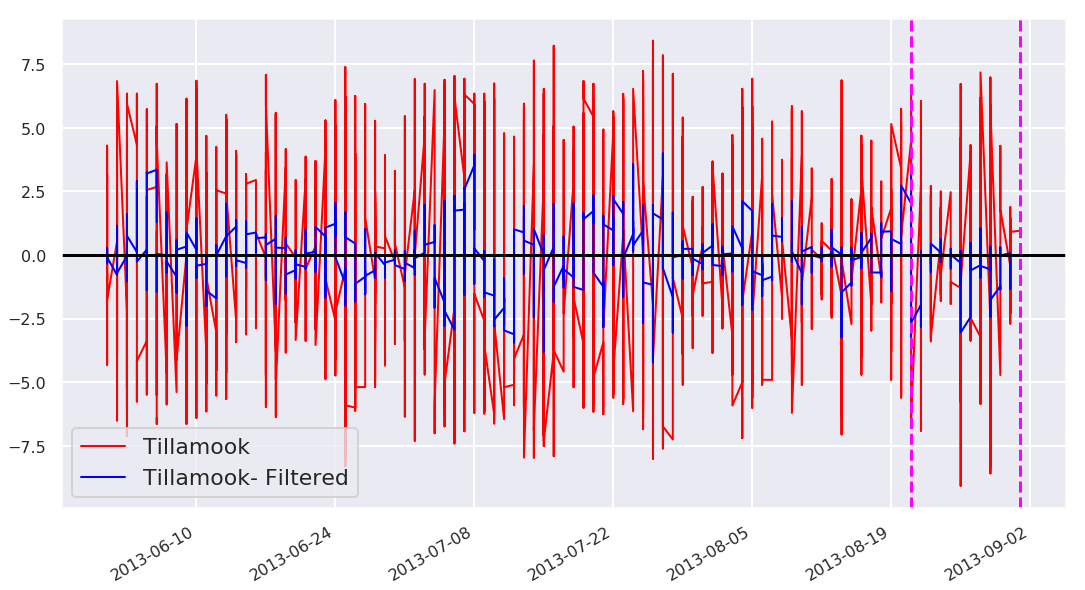

In [110]:
step = 1
order = 4
fs = 1/(3600)      # sample rate, Hz
cutoff = 1/(72*3600)  # desired cutoff frequency of the filter, Hz



from scipy import signal
# b, a = signal.butter(2, 0.01, btype='lowpass', analog=True)
b, a = butter_lowpass(cutoff, fs, order)
# b, a = signal.iirdesign(wp = 0.33, ws= 0.1, gstop= 10, gpass=1, ftype='cheby1')
low_passed_v = signal.filtfilt(b, a, v_wind_oregon[::step])


# low_passed_u = signal.filtfilt(b, a, u_wind_oregon[::step])
# low_passed_mag = signal.filtfilt(b, a, wind_spd_oregon[::step])

fig,ax1 = plt.subplots(1, 1, figsize=(18,10))

# ax1.plot(time_axis ,filt_v[::step], 'b-',linewidth=2, label = 'La Perouse')
ax1.plot(time_axis_oregon ,v_wind_oregon[:], 'r-',linewidth=2, label = 'Tillamook')
# ax1.plot(time_axis ,filt_v[::step], 'r-',linewidth=2, label = 'La Perouse')
ax1.plot(time_axis_oregon ,lowPassFilteredSignal, 'b-',linewidth=2, label = 'Tillamook- Filtered')



# ax1.plot(time_axis_orford ,filt_v_orford[::step], 'cyan',linewidth=2)


# ax1.legend(['Filtered'])
# ax1.set_title("Meridional Wind speed at La Perouse", fontsize = 16)
ax1.axhline(y=0, color = 'k')
ax1.axvline(x = time_axis[1944], color = 'magenta', linestyle  = '--')
ax1.axvline(x = time_axis[-1], color = 'magenta', linestyle  = '--')
ax1.tick_params(axis='both',labelsize =16)
# ax1.set_ylim(-2.5,2.5)
ax1.grid()
ax1.legend(loc='best')

fig.autofmt_xdate()

In [12]:
mat_file = '/data/ssahu/Falkor_2013/winds/wind_Newport_2013_v6.mat'

mat = scipy.io.loadmat(mat_file)

wind_stress_newport = mat['tau'][:,0]



date1_Newport = '2013-01-02'
date2_Newport = '2013-12-30'
mydates_Newport = pd.date_range(date1_Newport, date2_Newport, freq= 'D')



# import tables
# file = tables.open_file(mat_file, mode='r')



In [46]:
def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in np.arange(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1, join_axes=[df.index])
    return df









"""
Constants
=========
"""

# ---- physical constants
g = 9.8  # 9.7803 in COARE FIXME: change to sw.grav
""" acceleration due to gravity [m s :sup:`-2`] """

sigmaSB = 5.6697e-8
""" Stefan-Boltzmann constant [W m :sup:`-2` K :sup:`-4`] """

eps_air = 0.62197
""" Molecular weight ratio [water air :sup:`-1`] """

CtoK = 273.15  # 273.16
""" Conversion factor for [:math:`^\\circ` C] to [:math:`^\\circ` K] """

gas_const_R = 287.04  # NOTE: 287.1 in COARE
""" Gas constant for dry air [J kg :sup:`-1` K :sup:`-1`] """


# ---- meteorological constants
kappa = 0.4  # NOTE: 0.41
""" von Karman's constant """

charn = Charnock_alpha = 0.011  # NOTE: 0.018
""" Charnock constant. For determining roughness length at sea given friction
velocity, used in Smith formulas for drag coefficient and also in Fairall and
Edson. Ese alpha = 0.011 for open-ocean and alpha = 0.018 for fetch-limited
(coastal) regions."""

R_roughness = 0.11
""" limiting roughness Reynolds for aerodynamically smooth flow """


# ---- defaults suitable for boundary-layer studies
cp = 1004.7
""" heat capacity of air [J kg :sup:`-1` K :sup:`-1`] """

Qsat_coeff = 0.98
""" saturation specific humidity coefficient reduced by 2% over salt water """


# ------ short-wave flux calculations
Solar_const = 1368.0
""" The solar constant [W/m^2] represents a mean of satellite measurements
made over the last sunspot cycle (1979-1995) taken from Coffey et al (1995),
Earth System Monitor, 6, 6-10."""


# ---- long-wave flux calculations
emiss_lw = 0.985
""" long-wave emissivity of ocean from Dickey et al (1994), J. Atmos. Oceanic
Tech., 11, 1057-1076."""

# Default values
P_default = 1020.





def stress(sp, z=5., drag='largepond', rho_air=1.22, Ta=10.):
    """Computes the neutral wind stress.
    Parameters
    ----------
    sp : array_like
         wind speed [m s :sup:`-1`]
    z : float, array_like, optional
        measurement height [m]
    rho_air : array_like, optional
           air density [kg m :sup:`-3`]
    drag : str
           neutral drag by:
           'largepond' <-- default
           'smith'
           'vera'
    Ta : array_like, optional
         air temperature [:math:`^\\circ` C]
    Returns
    -------
    tau : array_like
          wind stress  [N m :sup:`-2`]
    See Also
    --------
    cdn
    Examples
    --------
    >>> from airsea import windstress as ws
    >>> ws.stress([10., 0.2, 12., 20., 30., 50.], 10)
    array([  1.40300000e-01,   5.61200000e-05,   2.23113600e-01,
             8.73520000e-01,   2.67912000e+00,   1.14070000e+01])
    >>> kw = dict(rho_air=1.02, Ta=23.)
    >>> ws.stress([10., 0.2, 12., 20., 30., 50.], 15, 'smith', **kw)
    array([  1.21440074e-01,   5.32531576e-05,   1.88322389e-01,
             6.62091968e-01,   1.85325310e+00,   7.15282267e+00])
    >>> ws.stress([10., 0.2, 12., 20., 30., 50.], 8, 'vera')
    array([  1.50603698e-01,   7.16568379e-04,   2.37758830e-01,
             9.42518454e-01,   3.01119044e+00,   1.36422742e+01])
    References
    ----------
    .. [1] Large and Pond (1981), J. Phys. Oceanog., 11, 324-336.
    .. [2] Smith (1988), J. Geophys. Res., 93, 311-326.
    .. [3] E. Vera (1983) FIXME eqn. 8 in Large, Morzel, and Crawford (1995),
    J. Phys. Oceanog., 25, 2959-2971.
    Modifications: Original from AIR_SEA TOOLBOX, Version 2.0
    03-08-1997: version 1.0
    08-26-1998: version 1.1 (revised by RP)
    04-02-1999: versin 1.2 (air density option added by AA)
    08-05-1999: version 2.0
    11-26-2010: Filipe Fernandes, Python translation.
    """
    z, sp = np.asarray(z), np.asarray(sp)
    Ta, rho_air = np.asarray(Ta), np.asarray(rho_air)

    # Find cd and ustar.
    if drag == 'largepond':
        cd, sp = cdn(sp, z, 'largepond')
    elif drag == 'smith':
        cd, sp = cdn(sp, z, 'smith', Ta)
    elif drag == 'vera':
        cd, sp = cdn(sp, z, 'vera')
    else:
        print('Unknown method')  # FIXME: raise a proper python error

    tau = rho_air * (cd * sp ** 2)

    return tau


def cdn(sp, z, drag='largepond', Ta=10):
    """Computes neutral drag coefficient.
    Methods available are: Large & Pond (1981),  Vera (1983) or Smith (1988)
    Parameters
    ----------
    sp : array_like
         wind speed [m s :sup:`-1`]
    z : float, array_like
        measurement height [m]
    drag : str
           neutral drag by:
           'largepond' <-- default
           'smith'
           'vera'
    Ta : array_like, optional for drag='smith'
         air temperature [:math:`^\\circ` C]
    Returns
    -------
    cd : float, array_like
         neutral drag coefficient at 10 m
    u10 : array_like
          wind speed at 10 m [m s :sup:`-1`]
    See Also
    --------
    stress, spshft, visc_air
    Notes
    -----
    Vera (1983): range of fit to data is 1 to 25 [m s :sup:`-1`].
    Examples
    --------
    >>> from airsea import windstress as ws
    >>> ws.cdn([10., 0.2, 12., 20., 30., 50.], 10)
    (array([ 0.00115,  0.00115,  0.00127,  0.00179,  0.00244,  0.00374]),
     array([ 10. ,   0.2,  12. ,  20. ,  30. ,  50. ]))
    >>> ws.cdn([10., 0.2, 12., 20., 30., 50.], 15, 'vera')
    (array([ 0.00116157,  0.01545237,  0.00126151,  0.00174946,  0.00242021,
            0.00379521]),
     array([  9.66606155,   0.17761896,  11.58297824, 19.18652915,
            28.5750255 ,  47.06117334]))
    >>> ws.cdn([10., 0.2, 12., 20., 30., 50.], 20, 'smith', 20.)
    (array([ 0.00126578,  0.00140818,  0.00136533,  0.00173801,  0.00217435,
            0.00304636]),
     array([  9.41928554,   0.18778865,  11.27787697,  18.65250005,
            27.75712916,  45.6352786 ]))
    References
    ----------
    .. [1] Large and Pond (1981), J. Phys. Oceanog., 11, 324-336.
    .. [2] Smith (1988), J. Geophys. Res., 93, 311-326.
    .. [3] E. Vera (1983) FIXME eqn. 8 in Large, Morzel, and Crawford (1995),
    J. Phys. Oceanog., 25, 2959-2971.
    Modifications: Original from AIR_SEA TOOLBOX, Version 2.0
    03-08-1997: version 1.0
    08-26-1998: version 1.1 (vectorized by RP)
    08-05-1999: version 2.0
    11-26-2010: Filipe Fernandes, Python translation.
    """
    # convert input to numpy array
    sp, z, Ta = np.asarray(sp), np.asarray(z), np.asarray(Ta)

    tol = 0.00001  # Iteration end point.

    if drag == 'largepond':
        a = np.log(z / 10.) / kappa  # Log-layer correction factor.
        u10o = np.zeros(sp.shape)
        cd = 1.15e-3 * np.ones(sp.shape)
        u10 = sp / (1 + a * np.sqrt(cd))
        ii = np.abs(u10 - u10o) > tol

        while np.any(ii):
            u10o = u10
            cd = (4.9e-4 + 6.5e-5 * u10o)  # Compute cd(u10).
            cd[u10o < 10.15385] = 1.15e-3
            u10 = sp / (1 + a * np.sqrt(cd))  # Next iteration.
            # Keep going until iteration converges.
            ii = np.abs(u10 - u10o) > tol

    elif drag == 'smith':
        visc = visc_air(Ta)

        # Remove any sp==0 to prevent division by zero
        # i = np.nonzero(sp == 0)
        # sp[i] = 0.1 * np.ones(len(i)) FIXME

        # initial guess
        ustaro = np.zeros(sp.shape)
        ustarn = 0.036 * sp

        # iterate to find z0 and ustar
        ii = np.abs(ustarn - ustaro) > tol
        while np.any(ii):
            ustaro = ustarn
            z0 = Charnock_alpha * ustaro ** 2 / g + R_roughness * visc / ustaro
            ustarn = sp * (kappa / np.log(z / z0))
            ii = np.abs(ustarn - ustaro) > tol

        sqrcd = kappa / np.log(10. / z0)
        cd = sqrcd ** 2
        u10 = ustarn / sqrcd
    elif drag == 'vera':
        # constants in fit for drag coefficient
        A = 2.717e-3
        B = 0.142e-3
        C = 0.0764e-3

        a = np.log(z / 10.) / kappa  # Log-layer correction factor.
        # Don't start iteration at 0 to prevent blowups.
        u10o = np.zeros(sp.shape) + 0.1
        cd = A / u10o + B + C * u10o
        u10 = sp / (1 + a * np.sqrt(cd))

        ii = np.abs(u10 - u10o) > tol
        while np.any(ii):
            u10o = u10
            cd = A / u10o + B + C * u10o
            u10 = sp / (1 + a * np.sqrt(cd))  # Next iteration.
            # Keep going until iteration converges.
            ii = np.abs(u10 - u10o) > tol
    else:
        print('Unknown method')  # FIXME: raise a proper python error.

    return cd, u10


In [19]:
La_perouse_stress = stress(sp=filt_v)

In [20]:
La_perouse_stress

array([  1.70027019e-04,   1.70027019e-04,   1.68548648e-04, ...,
         9.71406238e-05,   1.00809393e-04,   1.02536350e-04])

In [46]:
np.min(La_perouse_stress)

3.3626563253525103e-10

In [21]:
mydates_Newport.shape

(365,)

In [74]:
mydates_Newport[241:-121].shape

(3,)

In [14]:
A1_data = pd.read_table('/data/ssahu/IOS_data/ADCP_E1_A1/a1_20130707_20140524_0498m.csv',delim_whitespace=1,header = None, skiprows=426)

str_stuff = np.array(['Record_Number', 'Date', 'Time', 'Pitch', 'Roll', 'Heading', 'Pressure', 'Temperature'], dtype = 'str')

bin_depths = np.array([84.44, 100.44, 116.44, 132.44, 148.44, 164.44, 180.44, 196.44, 212.44, 228.44, 244.44, 260.44, 276.44\
              , 292.44, 308.44, 324.44, 340.44, 356.44, 372.44, 388.44, 404.44, 420.44, 436.44, 452.44, 468.44], dtype = 'str')

variables = np.array(['vel_north', 'vel_east', 'vel_vert', 'back_scatter_mean'], dtype = 'str')

column_data = []

for j in bin_depths:
    for i in variables:
        column_data = np.append(arr=column_data, values=i+'_'+j)
    

columns_A1 = np.concatenate((str_stuff, column_data), axis = 0)

A1_data.columns = columns_A1

In [15]:
vel_north_84 = np.array(A1_data['vel_north_84.44'], dtype = np.float)[:5284]
vel_east_84  = np.array(A1_data['vel_east_84.44'], dtype = np.float)[:5284]
mag_84       = np.sqrt(vel_east_84**2+vel_north_84**2)
mag_84[mag_84 > 2] = 'Nan'

vel_north_100= np.array(A1_data['vel_north_100.44'], dtype = np.float)[:5284]
vel_east_100 = np.array(A1_data['vel_east_100.44'], dtype = np.float)[:5284]
mag_100       = np.sqrt(vel_east_100**2+vel_north_100**2)
mag_100[mag_100 > 2] = 'Nan'

vel_north_116 = np.array(A1_data['vel_north_116.44'], dtype = np.float)[:5284]
vel_east_116  = np.array(A1_data['vel_east_116.44'], dtype = np.float)[:5284]
mag_116       = np.sqrt(vel_east_116**2+vel_north_116**2)
mag_116[mag_116 > 2] = 'Nan'

vel_north_148 = np.array(A1_data['vel_north_148.44'], dtype = np.float)[:5284]
vel_east_148  = np.array(A1_data['vel_east_148.44'], dtype = np.float)[:5284]
mag_148       = np.sqrt(vel_east_148**2+vel_north_148**2)

vel_north_164= np.array(A1_data['vel_north_164.44'], dtype = np.float)[:5284]
vel_east_164 = np.array(A1_data['vel_east_164.44'], dtype = np.float)[:5284]
mag_164       = np.sqrt(vel_east_164**2+vel_north_164**2)
mag_164[mag_164 > 2] = 'Nan'

vel_north_180= np.array(A1_data['vel_north_180.44'], dtype = np.float)[:5284]
vel_east_180 = np.array(A1_data['vel_east_180.44'], dtype = np.float)[:5284]
mag_180       = np.sqrt(vel_east_180**2+vel_north_180**2)
mag_180[mag_180 > 2] = 'Nan'

vel_north_196 = np.array(A1_data['vel_north_196.44'], dtype = np.float)[:5284]
vel_east_196  = np.array(A1_data['vel_east_196.44'], dtype = np.float)[:5284]
mag_196      = np.sqrt(vel_east_196**2+vel_north_196**2)

vel_north_228 = np.array(A1_data['vel_north_228.44'], dtype = np.float)[:5284]
vel_east_228 = np.array(A1_data['vel_east_228.44'], dtype = np.float)[:5284]
mag_228      = np.sqrt(vel_east_228**2+vel_north_228**2)

vel_north_260 = np.array(A1_data['vel_north_260.44'], dtype = np.float)[:5284]
vel_east_260 = np.array(A1_data['vel_east_260.44'], dtype = np.float)[:5284]
mag_260      = np.sqrt(vel_east_260**2+vel_north_260**2)

vel_north_276 = np.array(A1_data['vel_north_276.44'], dtype = np.float)[:5284]
vel_east_276 = np.array(A1_data['vel_east_276.44'], dtype = np.float)[:5284]
mag_276      = np.sqrt(vel_east_276**2+vel_north_276**2)

vel_north_292 = np.array(A1_data['vel_north_292.44'], dtype = np.float)[:5284]
vel_east_292 = np.array(A1_data['vel_east_292.44'], dtype = np.float)[:5284]
mag_292      = np.sqrt(vel_east_292**2+vel_north_292**2)

vel_north_308 = np.array(A1_data['vel_north_308.44'], dtype = np.float)[:5284]
vel_east_308 = np.array(A1_data['vel_east_308.44'], dtype = np.float)[:5284]
mag_308      = np.sqrt(vel_east_308**2+vel_north_308**2)

vel_north_340 = np.array(A1_data['vel_north_340.44'], dtype = np.float)[:5284]
vel_east_340 = np.array(A1_data['vel_east_340.44'], dtype = np.float)[:5284]
mag_340      = np.sqrt(vel_east_340**2+vel_north_340**2)

vel_north_372 = np.array(A1_data['vel_north_372.44'], dtype = np.float)[:5284]
vel_east_372 = np.array(A1_data['vel_east_372.44'], dtype = np.float)[:5284]
mag_372      = np.sqrt(vel_east_372**2+vel_north_372**2)

vel_north_388 = np.array(A1_data['vel_north_388.44'], dtype = np.float)[:5284]
vel_east_388 = np.array(A1_data['vel_east_388.44'], dtype = np.float)[:5284]
mag_388      = np.sqrt(vel_east_388**2+vel_north_388**2)

In [16]:
tarikh = np.array(A1_data['Date'], dtype = np.str)
samai  = np.array(A1_data['Time'], dtype = np.str)

time = np.empty_like(tarikh)

for i in np.arange(tarikh.shape[0]):
    time[i] = tarikh[i] + '' + samai[i]


datetime_A1 = np.empty_like(time)

for i in np.arange(datetime_A1.shape[0]):
    datetime_A1[i] = datetime.strptime(time[i], '%Y/%m/%d%H:%M:%S')
    
datetime_A1 = datetime_A1.astype(np.datetime64)


In [17]:
mydates_A1 = np.array(pd.date_range(datetime_A1[:5284][0], datetime_A1[:5284][-1], freq="30min"))

In [18]:
A1_series_east = pd.Series(vel_east_84, index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_84_daily_east = daily_east.values
east_84 = np.divide(vel_84_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_84, index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_84_daily_north = daily_north.values
north_84 = np.divide(vel_84_daily_north[:], 24)


Speed_84 = np.sqrt(east_84**2 + north_84**2)


A1_series_east = pd.Series(vel_east_148, index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_148_daily_east = daily_east.values
east_148 = np.divide(vel_148_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_148, index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_148_daily_north = daily_north.values
north_148 = np.divide(vel_148_daily_north[:], 24)


Speed_148 = np.sqrt(east_148**2 + north_148**2)


A1_series_east = pd.Series(vel_east_196, index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_196_daily_east = daily_east.values
east_196 = np.divide(vel_196_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_196, index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_196_daily_north = daily_north.values
north_196 = np.divide(vel_196_daily_north[:], 24)


Speed_196 = np.sqrt(east_196**2 + north_196**2)


A1_series_east = pd.Series(vel_east_228, index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_228_daily_east = daily_east.values
east_228 = np.divide(vel_228_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_228, index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_228_daily_north = daily_north.values
north_228 = np.divide(vel_228_daily_north[:], 24)


Speed_228 = np.sqrt(east_228**2 + north_228**2)


A1_series_east = pd.Series(vel_east_260, index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_260_daily_east = daily_east.values
east_260 = np.divide(vel_260_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_260, index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_260_daily_north = daily_north.values
north_260 = np.divide(vel_260_daily_north[:], 24)


Speed_260 = np.sqrt(east_260**2 + north_260**2)

A1_series_east = pd.Series(vel_east_308, index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_308_daily_east = daily_east.values
east_308 = np.divide(vel_308_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_308, index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_308_daily_north = daily_north.values
north_308 = np.divide(vel_308_daily_north[:], 24)

Speed_308 = np.sqrt(east_308**2 + north_308**2)


A1_series_east = pd.Series(vel_east_340, index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_340_daily_east = daily_east.values
east_340 = np.divide(vel_340_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_340, index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_340_daily_north = daily_north.values
north_340 = np.divide(vel_340_daily_north[:], 24)


Speed_340 = np.sqrt(east_340**2 + north_340**2)


A1_series_east = pd.Series(vel_east_372, index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_372_daily_east = daily_east.values
east_372 = np.divide(vel_372_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_372, index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_372_daily_north = daily_north.values
north_372 = np.divide(vel_372_daily_north[:], 24)


Speed_372 = np.sqrt(east_372**2 + north_372**2)


A1_series_east = pd.Series(vel_east_388, index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_388_daily_east = daily_east.values
east_388 = np.divide(vel_388_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_388, index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_388_daily_north = daily_north.values
north_388 = np.divide(vel_388_daily_north[:], 24)


Speed_388 = np.sqrt(east_388**2 + north_388**2)


In [19]:
mydates_A1 = np.array(pd.date_range(datetime_A1[1200:2600][0], datetime_A1[1200:2600][-1], freq="30min"))

In [20]:
A1_series_east = pd.Series(vel_east_84[1200:2600], index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_84_daily_east = daily_east.values
east_84 = np.divide(vel_84_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_84[1200:2600], index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_84_daily_north = daily_north.values
north_84 = np.divide(vel_84_daily_north[:], 24)


Speed_84 = np.sqrt(east_84**2 + north_84**2)

A1_series_east = pd.Series(vel_east_100[1200:2600], index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_100_daily_east = daily_east.values
east_100 = np.divide(vel_100_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_100[1200:2600], index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_100_daily_north = daily_north.values
north_100 = np.divide(vel_100_daily_north[:], 24)


Speed_100 = np.sqrt(east_100**2 + north_100**2)


A1_series_east = pd.Series(vel_east_148[1200:2600], index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_148_daily_east = daily_east.values
east_148 = np.divide(vel_148_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_148[1200:2600], index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_148_daily_north = daily_north.values
north_148 = np.divide(vel_148_daily_north[:], 24)


Speed_148 = np.sqrt(east_148**2 + north_148**2)


A1_series_east = pd.Series(vel_east_196[1200:2600], index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_196_daily_east = daily_east.values
east_196 = np.divide(vel_196_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_196[1200:2600], index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_196_daily_north = daily_north.values
north_196 = np.divide(vel_196_daily_north[:], 24)


Speed_196 = np.sqrt(east_196**2 + north_196**2)


A1_series_east = pd.Series(vel_east_228[1200:2600], index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_228_daily_east = daily_east.values
east_228 = np.divide(vel_228_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_228[1200:2600], index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_228_daily_north = daily_north.values
north_228 = np.divide(vel_228_daily_north[:], 24)


Speed_228 = np.sqrt(east_228**2 + north_228**2)


A1_series_east = pd.Series(vel_east_260[1200:2600], index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_260_daily_east = daily_east.values
east_260 = np.divide(vel_260_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_260[1200:2600], index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_260_daily_north = daily_north.values
north_260 = np.divide(vel_260_daily_north[:], 24)


Speed_260 = np.sqrt(east_260**2 + north_260**2)


A1_series_east = pd.Series(vel_east_340[1200:2600], index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_340_daily_east = daily_east.values
east_340 = np.divide(vel_340_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_340[1200:2600], index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_340_daily_north = daily_north.values
north_340 = np.divide(vel_340_daily_north[:], 24)


Speed_340 = np.sqrt(east_340**2 + north_340**2)


A1_series_east = pd.Series(vel_east_388[1200:2600], index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_388_daily_east = daily_east.values
east_388 = np.divide(vel_388_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_388[1200:2600], index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_388_daily_north = daily_north.values
north_388 = np.divide(vel_388_daily_north[:], 24)


Speed_388 = np.sqrt(east_388**2 + north_388**2)


A1_series_east = pd.Series(vel_east_372[1200:2600], index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_372_daily_east = daily_east.values
east_372 = np.divide(vel_372_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_372[1200:2600], index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_372_daily_north = daily_north.values
north_372 = np.divide(vel_372_daily_north[:], 24)


Speed_372 = np.sqrt(east_372**2 + north_372**2)


A1_series_east = pd.Series(vel_east_308[1200:2600], index=mydates_A1)
daily_east = A1_series_east.resample('1440T').sum()
vel_308_daily_east = daily_east.values
east_308 = np.divide(vel_308_daily_east[:], 24)

A1_series_north = pd.Series(vel_north_308[1200:2600], index=mydates_A1)
daily_north = A1_series_north.resample('1440T').sum()
vel_308_daily_north = daily_north.values
north_308 = np.divide(vel_308_daily_north[:], 24)

Speed_308 = np.sqrt(east_308**2 + north_308**2)

In [21]:
date1 = '2013-08-01'
date2 = '2013-08-31'
mydates_A1_1 = pd.date_range(date1, date2, freq= 'D')

In [22]:
colors = cm.copper(np.linspace(0, 1, 50))

colors_speed = cm.Greens(np.linspace(0, 1, 50))

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:60: RuntimeWarning: invalid value encountered in less


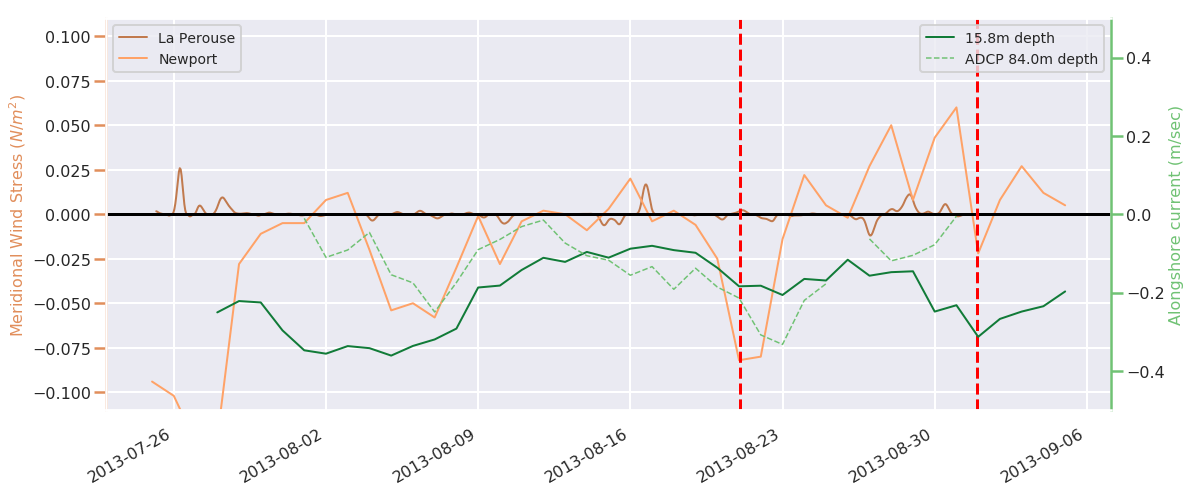

In [24]:

step = 1
window_size_1 = 24



time_axis = datetime_2013[::step]






s_v = v_wind[:]   
filt_v = smooth(s_v,window_size_1,'hanning')

s_u = u_wind[:]   
filt_u = smooth(s_u,window_size_1,'hanning')

s_wind = wind_spd[:]
filt_wind = smooth(s_wind,window_size_1,'hanning')

La_perouse_stress = np.sign(filt_v)*stress(sp=filt_v)




fig, ax1 = plt.subplots(1, 1, figsize=(18,8))

# ax1.plot(time_axis[1300:] ,filt_v[1300:], 'b-',linewidth=2, label = 'La Perouse')

ax1.plot(time_axis[1300:] ,La_perouse_stress[1300:], color = colors[30],linewidth=2, label = 'La Perouse')

ax1.plot(mydates_Newport[204:-116], wind_stress_newport[204:-116], c = colors[40], linewidth=2, label = 'Newport')
# ax1.plot(time_axis_orford ,filt_v_orford[::step], 'cyan',linewidth=2)


# ax1.legend(['Filtered'])
# ax1.set_title("Meridional Wind speed", fontsize = 16)
ax1.axhline(y=0, color = 'k')
ax1.axvline(x = time_axis[1944], color = 'r', linestyle  = '--')
ax1.axvline(x = time_axis[-1], color = 'r', linestyle  = '--')
ax1.tick_params(axis='both',labelsize =16)
ax1.set_ylim(-0.11,0.11)
ax1.set_ylabel('Meridional Wind Stress ($N/m^2$)', fontsize = 16)# and Wind stress (*10^3) (N/m^2)', fontsize = 16)
ax1.grid()
ax1.legend(loc='best', fontsize = 14)
ax1.yaxis.label.set_color(colors[35])
ax1.tick_params(axis='both',labelsize =16, color = colors[35])


ax2 = ax1.twinx()
ax2.plot(mydates[90:-50], v_unrotated[90:-50,10,j,i], c = colors_speed[40], linewidth=2, label = '{0:0.1f}m depth'.format(zlevels[10]))
# ax2.plot(mydates[90:-50], v_unrotated[90:-50,22,j,i], c = colors_speed[25], linewidth=1, label = '{0:0.1f}m depth'.format(zlevels[22]))
# ax2.plot(mydates[90:-50], v_unrotated[90:-50,25,j,i], c = colors_speed[30], linewidth=1.5, label = '{0:0.1f}m depth'.format(zlevels[25]))


# ax2.plot(mydates_A1_1, north_148, 'magenta', linewidth=1.5, linestyle = 'dashed', label = 'ADCP {0:0.1f}m depth'.format(148))

north_84[north_84 < -2] = 'Nan'
ax2.plot(mydates_A1_1, north_84, color = colors_speed[25], linewidth=1.5,linestyle = 'dashed', label = 'ADCP {0:0.1f}m depth'.format(84))
# # ax3 = ax1.twinx()
# # ax1.plot(mydates_Newport[1:-1], wind_stress_newport[:])#, 'golden', linewidth=2, label = 'Newport')
# # ax3.set_yticklabels([])

ax2.set_ylabel('Alongshore current (m/sec)', fontsize = 16)
ax2.set_ylim(-0.5, 0.5)
ax2.tick_params(axis='both',labelsize =16, color = colors_speed[25])
ax2.yaxis.label.set_color(colors_speed[25])
ax2.legend(loc = 'best', fontsize  =14)
ax2.spines['right'].set_color(colors_speed[25])
ax1.spines['left'].set_color(colors[35])



# offset = 60
# new_fixed_axis = ax2.get_grid_helper().new_fixed_axis
# ax2.axis["right"] = new_fixed_axis(loc="right",
#                                     axes=ax2,
#                                     offset=(offset, 0))

fig.autofmt_xdate()



/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:59: RuntimeWarning: invalid value encountered in less


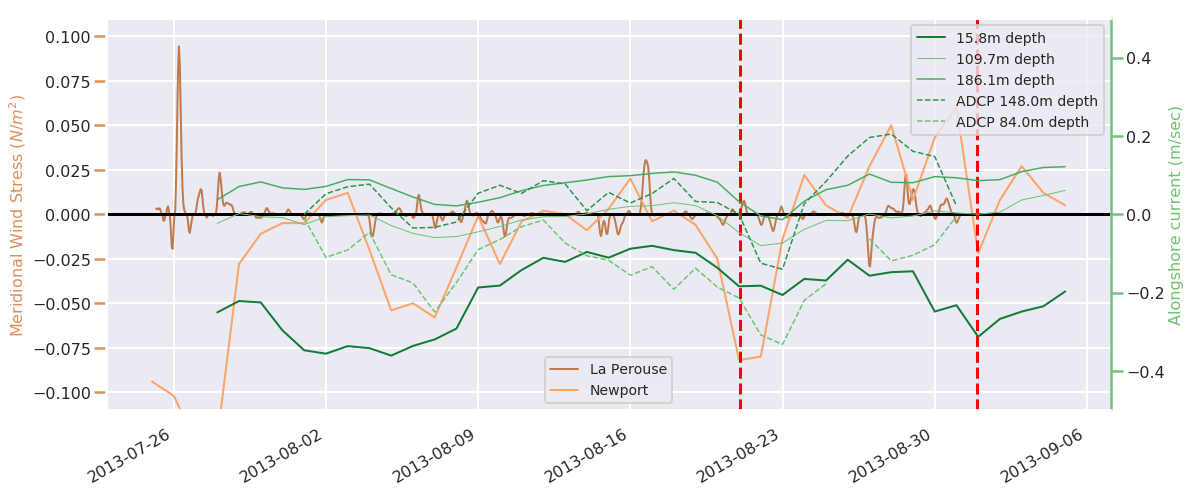

In [30]:

step = 1
window_size_1 = 12



time_axis = datetime_2013[::step]






s_v = v_wind[:]   
filt_v = smooth(s_v,window_size_1,'hanning')

s_u = u_wind[:]   
filt_u = smooth(s_u,window_size_1,'hanning')

s_wind = wind_spd[:]
filt_wind = smooth(s_wind,window_size_1,'hanning')

La_perouse_stress = np.sign(filt_v)*stress(sp=filt_v)




fig, ax1 = plt.subplots(1, 1, figsize=(18,8))

# ax1.plot(time_axis[1300:] ,filt_v[1300:], 'b-',linewidth=2, label = 'La Perouse')

ax1.plot(time_axis[1300:] , La_perouse_stress[1300:], color = colors[30],linewidth=2, label = 'La Perouse')

ax1.plot(mydates_Newport[204:-116], wind_stress_newport[204:-116], c = colors[40], linewidth=2, label = 'Newport')
# ax1.plot(time_axis_orford ,filt_v_orford[::step], 'cyan',linewidth=2)


# ax1.legend(['Filtered'])
# ax1.set_title("Meridional Wind speed", fontsize = 16)
ax1.axhline(y=0, color = 'k')
ax1.axvline(x = time_axis[1944], color = 'r', linestyle  = '--')
ax1.axvline(x = time_axis[-1], color = 'r', linestyle  = '--')
ax1.tick_params(axis='both',labelsize =16)
ax1.set_ylim(-0.11,0.11)
ax1.set_ylabel('Meridional Wind Stress ($N/m^2$)', fontsize = 16)# and Wind stress (*10^3) (N/m^2)', fontsize = 16)
ax1.grid()
ax1.legend(loc='best', fontsize = 14)
ax1.yaxis.label.set_color(colors[35])
ax1.tick_params(axis='both',labelsize =16, color = colors[35])

ax2 = ax1.twinx()
ax2.plot(mydates[90:-50], v_unrotated[90:-50,10,j,i], c = colors_speed[40], linewidth=2, label = '{0:0.1f}m depth'.format(zlevels[10]))
ax2.plot(mydates[90:-50], v_unrotated[90:-50,22,j,i], c = colors_speed[25], linewidth=1, label = '{0:0.1f}m depth'.format(zlevels[22]))
ax2.plot(mydates[90:-50], v_unrotated[90:-50,25,j,i], c = colors_speed[30], linewidth=1.5, label = '{0:0.1f}m depth'.format(zlevels[25]))


ax2.plot(mydates_A1_1, north_148, color = colors_speed[35], linewidth=1.5, linestyle = 'dashed', label = 'ADCP {0:0.1f}m depth'.format(148))

north_84[north_84 < -2] = 'Nan'
ax2.plot(mydates_A1_1, north_84, color = colors_speed[25], linewidth=1.5,linestyle = 'dashed', label = 'ADCP {0:0.1f}m depth'.format(84))
# # ax3 = ax1.twinx()
# # ax1.plot(mydates_Newport[1:-1], wind_stress_newport[:])#, 'golden', linewidth=2, label = 'Newport')
# # ax3.set_yticklabels([])

ax2.set_ylabel('Alongshore current (m/sec)', fontsize = 16)
ax2.set_ylim(-0.5, 0.5)
ax2.tick_params(axis='both',labelsize =16, color = colors_speed[25])
ax2.yaxis.label.set_color(colors_speed[25])
ax2.legend(loc = 'best', fontsize  =14)
ax2.spines['right'].set_color(colors_speed[25])



# offset = 60
# new_fixed_axis = ax2.get_grid_helper().new_fixed_axis
# ax2.axis["right"] = new_fixed_axis(loc="right",
#                                     axes=ax2,
#                                     offset=(offset, 0))

fig.autofmt_xdate()



In [136]:
range = pd.date_range('2013-08-01T00:38', '2013-08-31T22:38', freq='60min')


df = pd.DataFrame(index = range)

df['La_Perouse_Wind_Stress'] = La_perouse_stress[1464:]

daily_wind_stress = pd.DataFrame()
daily_wind_stress['La Perouse'] = df.La_Perouse_Wind_Stress.resample('D').mean()
daily_wind_stress['Newport'] = wind_stress_newport[211:-121]


In [45]:
La_perouse_stress_daily.shape

(31,)

In [32]:
daily_wind_stress.corr()

La Perouse   Newport
La Perouse    1.000000  0.274923
Newport       0.274923  1.000000

In [78]:
NON_DER = mydates_Newport[211:-121]
df_new = df_derived_by_shift(daily_wind_stress, 5, NON_DER)

In [79]:
df_new

La Perouse  Newport  Newport_1  Newport_2  Newport_3  Newport_4  \
2013-08-01   -0.000860   -0.005        NaN        NaN        NaN        NaN   
2013-08-02   -0.000030    0.008     -0.005        NaN        NaN        NaN   
2013-08-03   -0.000123    0.012      0.008     -0.005        NaN        NaN   
2013-08-04   -0.002614   -0.020      0.012      0.008     -0.005        NaN   
2013-08-05    0.000554   -0.054     -0.020      0.012      0.008     -0.005   
2013-08-06    0.001169   -0.050     -0.054     -0.020      0.012      0.008   
2013-08-07   -0.001012   -0.058     -0.050     -0.054     -0.020      0.012   
2013-08-08    0.000608   -0.030     -0.058     -0.050     -0.054     -0.020   
2013-08-09   -0.001809   -0.001     -0.030     -0.058     -0.050     -0.054   
2013-08-10   -0.002966   -0.028     -0.001     -0.030     -0.058     -0.050   
2013-08-11    0.000009   -0.004     -0.028     -0.001     -0.030     -0.058   
2013-08-12    0.000005    0.002     -0.004     -0.028     -0.001     -0.030   
2013-08-13    0.000248    0.000      0.002     -0.004     -0.028     -0.001   
2013-08-14   -0.003659   -0.009      0.000      0.002     -0.004     -0.028   
2013-08-15   -0.003203    0.003     -0.009      0.000      0.002     -0.004   
2013-08-16    0.009820    0.020      0.003     -0.009      0.000      0.002   
2013-08-17   -0.000095   -0.004      0.020      0.003     -0.009      0.000   
2013-08-18   -0.000289    0.002     -0.004      0.020      0.003     -0.009   
2013-08-19   -0.000088   -0.006      0.002     -0.004      0.020      0.003   
2013-08-20   -0.001201   -0.025     -0.006      0.002     -0.004      0.020   
2013-08-21    0.001041   -0.082     -0.025     -0.006      0.002     -0.004   
2013-08-22   -0.002611   -0.080     -0.082     -0.025     -0.006      0.002   
2013-08-23   -0.000930   -0.014     -0.080     -0.082     -0.025     -0.006   
2013-08-24    0.000137    0.022     -0.014     -0.080     -0.082     -0.025   
2013-08-25   -0.000057    0.005      0.022     -0.014     -0.080     -0.082   
2013-08-26   -0.004918   -0.002      0.005      0.022     -0.014     -0.080   
2013-08-27   -0.003630    0.027     -0.002      0.005      0.022     -0.014   
2013-08-28    0.006648    0.050      0.027     -0.002      0.005      0.022   
2013-08-29    0.002749    0.008      0.050      0.027     -0.002      0.005   
2013-08-30    0.002657    0.043      0.008      0.050      0.027     -0.002   
2013-08-31   -0.000573    0.060      0.043      0.008      0.050      0.027   

            Newport_5  La Perouse_1  La Perouse_2  La Perouse_3  La Perouse_4  \
2013-08-01        NaN           NaN           NaN           NaN           NaN   
2013-08-02        NaN     -0.000860           NaN           NaN           NaN   
2013-08-03        NaN     -0.000030     -0.000860           NaN           NaN   
2013-08-04        NaN     -0.000123     -0.000030     -0.000860           NaN   
2013-08-05        NaN     -0.002614     -0.000123     -0.000030     -0.000860   
2013-08-06     -0.005      0.000554     -0.002614     -0.000123     -0.000030   
2013-08-07      0.008      0.001169      0.000554     -0.002614     -0.000123   
2013-08-08      0.012     -0.001012      0.001169      0.000554     -0.002614   
2013-08-09     -0.020      0.000608     -0.001012      0.001169      0.000554   
2013-08-10     -0.054     -0.001809      0.000608     -0.001012      0.001169   
2013-08-11     -0.050     -0.002966     -0.001809      0.000608     -0.001012   
2013-08-12     -0.058      0.000009     -0.002966     -0.001809      0.000608   
2013-08-13     -0.030      0.000005      0.000009     -0.002966     -0.001809   
2013-08-14     -0.001      0.000248      0.000005      0.000009     -0.002966   
2013-08-15     -0.028     -0.003659      0.000248      0.000005      0.000009   
2013-08-16     -0.004     -0.003203     -0.003659      0.000248      0.000005   
2013-08-17      0.002      0.009820     -0.003203     -0.003659      0.000248   
2013-08-18      0.000    

In [80]:
df_new.corr()

La Perouse   Newport  Newport_1  Newport_2  Newport_3  \
La Perouse      1.000000  0.274923   0.205126   0.086294   0.132116   
Newport         0.274923  1.000000   0.669160   0.263965   0.158592   
Newport_1       0.205126  0.669160   1.000000   0.627297   0.238451   
Newport_2       0.086294  0.263965   0.627297   1.000000   0.625795   
Newport_3       0.132116  0.158592   0.238451   0.625795   1.000000   
Newport_4       0.393223  0.002819   0.010810   0.130825   0.633471   
Newport_5       0.412832 -0.222081  -0.117729  -0.089250   0.100337   
La Perouse_1   -0.014731  0.013378   0.306772   0.225142   0.090261   
La Perouse_2   -0.278220  0.057306  -0.059011   0.267950   0.208691   
La Perouse_3   -0.063539  0.116870  -0.018251  -0.129292   0.251298   
La Perouse_4   -0.004119 -0.271534  -0.076424  -0.199843  -0.211562   
La Perouse_5    0.165011 -0.505315  -0.204743  -0.001912  -0.177190   

              Newport_4  Newport_5  La Perouse_1  La Perouse_2  La Perouse_3  \
La Perouse     0.393223   0.412832     -0.014731     -0.278220     -0.063539   
Newport        0.002819  -0.222081      0.013378      0.057306      0.116870   
Newport_1      0.010810  -0.117729      0.306772     -0.059011     -0.018251   
Newport_2      0.130825  -0.089250      0.225142      0.267950     -0.129292   
Newport_3      0.633471   0.100337      0.090261      0.208691      0.251298   
Newport_4      1.000000   0.592565      0.155372      0.022035      0.146646   
Newport_5      0.592565   1.000000      0.420059      0.110898     -0.035194   
La Perouse_1   0.155372   0.420059      1.000000     -0.009825     -0.278285   
La Perouse_2   0.022035   0.110898     -0.009825      1.000000     -0.046775   
La Perouse_3   0.146646  -0.035194     -0.278285     -0.046775      1.000000   
La Perouse_4   0.083858   0.017566     -0.057210     -0.417345     -0.159659   
La Perouse_5  -0.135846   0.158796     -0.012275     -0.016670     -0.390206   

              La Perouse_4  La Perouse_5  
La Perouse       -0.004119      0.165011  
Newport          -0.271534     -0.505315  
Newport_1        -0.076424     -0.204743  
Newport_2        -0.199843     -0.001912  
Newport_3        -0.211562     -0.177190  
Newport_4         0.083858     -0.135846  
Newport_5         0.017566      0.158796  
La Perouse_1     -0.057210     -0.012275  
La Perouse_2     -0.417345     -0.016670  
La Perouse_3     -0.159659     -0.390206  
La Perouse_4      1.000000     -0.060994  
La Perouse_5     -0.060994      1.000000

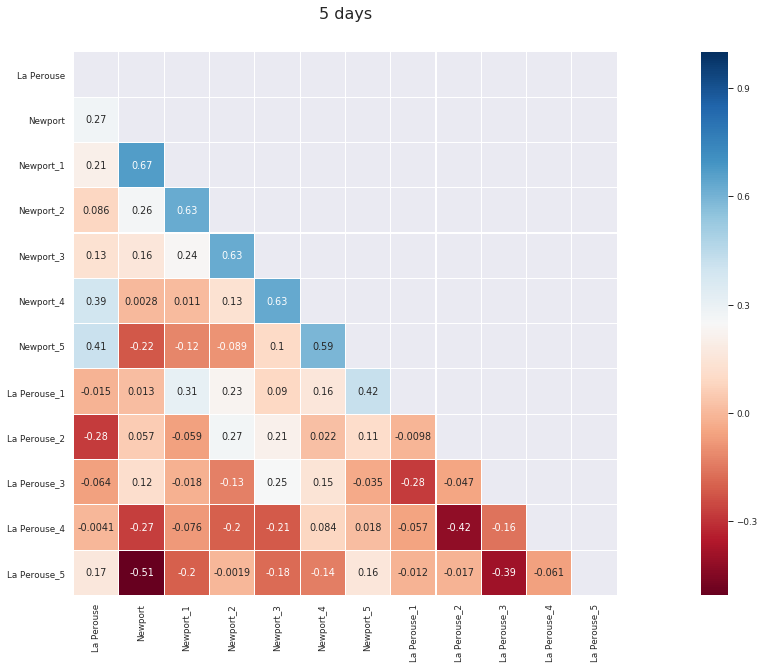

In [82]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
colormap = plt.cm.RdBu

sns.set_context('paper')

plt.figure(figsize=(30,10))
plt.title(u'5 days', y=1.05, size=16)

mask = np.zeros_like(df_new.corr())
mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(df_new.corr(), mask=mask, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [101]:
range = pd.date_range('2013-08-01', '2013-08-31', freq='D')


# df_adcp = pd.DataFrame(index = range)

# df_adcp['ADCP 84m'] = north_84

wind_stress_adcp_corr = pd.DataFrame(index = range)
wind_stress_adcp_corr['La Perouse'] = df.La_Perouse_Wind_Stress.resample('D').mean()
wind_stress_adcp_corr['Newport'] = wind_stress_newport[211:-121]
wind_stress_adcp_corr['ADCP 84m'] = north_84
# wind_stress_adcp_corr['NEP 15m'] = v_unrotated[94:-55,10,j,i]

# daily_wind_stress['Newport'] = wind_stress_newport[211:-121]


In [102]:
wind_stress_adcp_corr.corr()

La Perouse   Newport  ADCP 84m
La Perouse    1.000000  0.274923 -0.048723
Newport       0.274923  1.000000  0.526254
ADCP 84m     -0.048723  0.526254  1.000000

In [103]:
NON_DER = mydates_Newport[211:-121]
df_new = df_derived_by_shift(wind_stress_adcp_corr, 3, NON_DER)

In [104]:
df_new

La Perouse  Newport  ADCP 84m  Newport_1  Newport_2  Newport_3  \
2013-08-01   -0.000860   -0.005 -0.010569        NaN        NaN        NaN   
2013-08-02   -0.000030    0.008 -0.110187     -0.005        NaN        NaN   
2013-08-03   -0.000123    0.012 -0.091322      0.008     -0.005        NaN   
2013-08-04   -0.002614   -0.020 -0.046588      0.012      0.008     -0.005   
2013-08-05    0.000554   -0.054 -0.154557     -0.020      0.012      0.008   
2013-08-06    0.001169   -0.050 -0.175282     -0.054     -0.020      0.012   
2013-08-07   -0.001012   -0.058 -0.249583     -0.050     -0.054     -0.020   
2013-08-08    0.000608   -0.030 -0.174408     -0.058     -0.050     -0.054   
2013-08-09   -0.001809   -0.001 -0.090432     -0.030     -0.058     -0.050   
2013-08-10   -0.002966   -0.028 -0.064409     -0.001     -0.030     -0.058   
2013-08-11    0.000009   -0.004 -0.031588     -0.028     -0.001     -0.030   
2013-08-12    0.000005    0.002 -0.014963     -0.004     -0.028     -0.001   
2013-08-13    0.000248    0.000 -0.073626      0.002     -0.004     -0.028   
2013-08-14   -0.003659   -0.009 -0.105905      0.000      0.002     -0.004   
2013-08-15   -0.003203    0.003 -0.117435     -0.009      0.000      0.002   
2013-08-16    0.009820    0.020 -0.155841      0.003     -0.009      0.000   
2013-08-17   -0.000095   -0.004 -0.133750      0.020      0.003     -0.009   
2013-08-18   -0.000289    0.002 -0.191686     -0.004      0.020      0.003   
2013-08-19   -0.000088   -0.006 -0.137876      0.002     -0.004      0.020   
2013-08-20   -0.001201   -0.025 -0.185891     -0.006      0.002     -0.004   
2013-08-21    0.001041   -0.082 -0.214076     -0.025     -0.006      0.002   
2013-08-22   -0.002611   -0.080 -0.308124     -0.082     -0.025     -0.006   
2013-08-23   -0.000930   -0.014 -0.332492     -0.080     -0.082     -0.025   
2013-08-24    0.000137    0.022 -0.220055     -0.014     -0.080     -0.082   
2013-08-25   -0.000057    0.005 -0.177546      0.022     -0.014     -0.080   
2013-08-26   -0.004918   -0.002       NaN      0.005      0.022     -0.014   
2013-08-27   -0.003630    0.027 -0.063058     -0.002      0.005      0.022   
2013-08-28    0.006648    0.050 -0.119079      0.027     -0.002      0.005   
2013-08-29    0.002749    0.008 -0.104940      0.050      0.027     -0.002   
2013-08-30    0.002657    0.043 -0.077846      0.008      0.050      0.027   
2013-08-31   -0.000573    0.060 -0.005159      0.043      0.008      0.050   

            ADCP 84m_1  ADCP 84m_2  ADCP 84m_3  La Perouse_1  La Perouse_2  \
2013-08-01         NaN         NaN         NaN           NaN           NaN   
2013-08-02   -0.010569         NaN         NaN     -0.000860           NaN   
2013-08-03   -0.110187   -0.010569         NaN     -0.000030     -0.000860   
2013-08-04   -0.091322   -0.110187   -0.010569     -0.000123     -0.000030   
2013-08-05   -0.046588   -0.091322   -0.110187     -0.002614     -0.000123   
2013-08-06   -0.154557   -0.046588   -0.091322      0.000554     -0.002614   
2013-08-07   -0.175282   -0.154557   -0.046588      0.001169      0.000554   
2013-08-08   -0.249583   -0.175282   -0.154557     -0.001012      0.001169   
2013-08-09   -0.174408   -0.249583   -0.175282      0.000608     -0.001012   
2013-08-10   -0.090432   -0.174408   -0.249583     -0.001809      0.000608   
2013-08-11   -0.064409   -0.090432   -0.174408     -0.002966     -0.001809   
2013-08-12   -0.031588   -0.064409   -0.090432      0.000009     -0.002966   
2013-08-13   -0.014963   -0.031588   -0.064409      0.000005      0.000009   
2013-08-14   -0.073626   -0.014963   -0.031588      0.000248      0.000005   
2013-08-15   -0.105905   -0.073626   -0.014963     -0.003659      0.000248   
2013-08-16   -0.117435   -0.105905   -0.073626     -0.003203     -0.003659   
2013-08-17   -0.155841   -0.117435   -0.105905      0.009820     -0.003203   
2013-08-18   -0.133750   -0.155841   -0.117435     -0.000095      0.009820   
2013-08-19   -0.191686   -0.13375

In [105]:
df_new.corr()

La Perouse   Newport  ADCP 84m  Newport_1  Newport_2  Newport_3  \
La Perouse      1.000000  0.274923 -0.048723   0.205126   0.086294   0.132116   
Newport         0.274923  1.000000  0.526254   0.669160   0.263965   0.158592   
ADCP 84m       -0.048723  0.526254  1.000000   0.659479   0.489473   0.249405   
Newport_1       0.205126  0.669160  0.659479   1.000000   0.627297   0.238451   
Newport_2       0.086294  0.263965  0.489473   0.627297   1.000000   0.625795   
Newport_3       0.132116  0.158592  0.249405   0.238451   0.625795   1.000000   
ADCP 84m_1      0.120055  0.236967  0.735774   0.470994   0.622332   0.476945   
ADCP 84m_2      0.180504  0.009948  0.449013   0.200803   0.454588   0.615289   
ADCP 84m_3      0.161842 -0.056858  0.173217  -0.024822   0.185556   0.449695   
La Perouse_1   -0.014731  0.013378  0.047700   0.306772   0.225142   0.090261   
La Perouse_2   -0.278220  0.057306 -0.037221  -0.059011   0.267950   0.208691   
La Perouse_3   -0.063539  0.116870  0.122854  -0.018251  -0.129292   0.251298   

              ADCP 84m_1  ADCP 84m_2  ADCP 84m_3  La Perouse_1  La Perouse_2  \
La Perouse      0.120055    0.180504    0.161842     -0.014731     -0.278220   
Newport         0.236967    0.009948   -0.056858      0.013378      0.057306   
ADCP 84m        0.735774    0.449013    0.173217      0.047700     -0.037221   
Newport_1       0.470994    0.200803   -0.024822      0.306772     -0.059011   
Newport_2       0.622332    0.454588    0.185556      0.225142      0.267950   
Newport_3       0.476945    0.615289    0.449695      0.090261      0.208691   
ADCP 84m_1      1.000000    0.737892    0.450022     -0.039257     -0.009399   
ADCP 84m_2      0.737892    1.000000    0.737645      0.126465     -0.065797   
ADCP 84m_3      0.450022    0.737645    1.000000      0.182172      0.114612   
La Perouse_1   -0.039257    0.126465    0.182172      1.000000     -0.009825   
La Perouse_2   -0.009399   -0.065797    0.114612     -0.009825      1.000000   
La Perouse_3   -0.106785   -0.041617   -0.083147     -0.278285     -0.046775   

              La Perouse_3  
La Perouse       -0.063539  
Newport           0.116870  
ADCP 84m          0.122854  
Newport_1        -0.018251  
Newport_2        -0.129292  
Newport_3         0.251298  
ADCP 84m_1       -0.106785  
ADCP 84m_2       -0.041617  
ADCP 84m_3       -0.083147  
La Perouse_1     -0.278285  
La Perouse_2     -0.046775  
La Perouse_3      1.000000

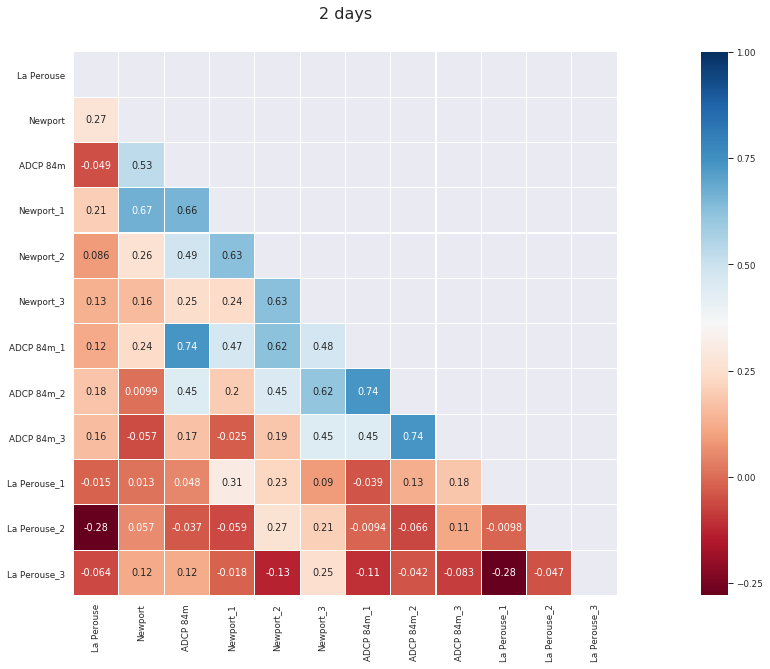

In [106]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
colormap = plt.cm.RdBu
plt.figure(figsize=(30,10))
plt.title(u'2 days', y=1.05, size=16)

mask = np.zeros_like(df_new.corr())
mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(df_new.corr(), mask=mask, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [107]:
range = pd.date_range('2013-08-01', '2013-08-31', freq='D')


# df_adcp = pd.DataFrame(index = range)

# df_adcp['ADCP 84m'] = north_84

wind_stress_adcp_corr = pd.DataFrame(index = range)
wind_stress_adcp_corr['La Perouse'] = df.La_Perouse_Wind_Stress.resample('D').mean()
wind_stress_adcp_corr['Newport'] = wind_stress_newport[211:-121]
# wind_stress_adcp_corr['ADCP 84m'] = north_84
wind_stress_adcp_corr['NEP 15m'] = v_unrotated[94:-55,10,j,i]

# daily_wind_stress['Newport'] = wind_stress_newport[211:-121]


In [108]:
NON_DER = mydates_Newport[211:-121]
df_new = df_derived_by_shift(wind_stress_adcp_corr, 3, NON_DER)

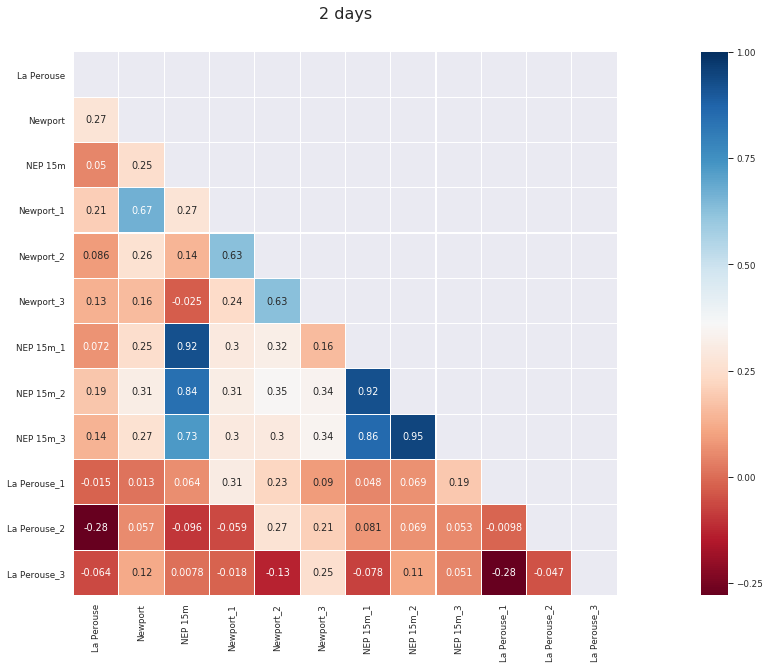

In [109]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
colormap = plt.cm.RdBu
plt.figure(figsize=(30,10))
plt.title(u'2 days', y=1.05, size=16)

mask = np.zeros_like(df_new.corr())
mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(df_new.corr(), mask=mask, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [138]:
range = pd.date_range('2013-08-01', '2013-08-31', freq='D')


# df_adcp = pd.DataFrame(index = range)

# df_adcp['ADCP 84m'] = north_84

wind_stress_adcp_corr = pd.DataFrame(index = range)
wind_stress_adcp_corr['La Perouse'] = df.La_Perouse_Wind_Stress.resample('D').mean()
wind_stress_adcp_corr['Newport'] = wind_stress_newport[211:-121]
# wind_stress_adcp_corr['ADCP 84m'] = north_84
wind_stress_adcp_corr['NEP 84m'] = v_unrotated[94:-55,21,j,i]

# daily_wind_stress['Newport'] = wind_stress_newport[211:-121]


In [134]:
zlevels[21]

92.326073

In [139]:
NON_DER = mydates_Newport[211:-121]
df_new = df_derived_by_shift(wind_stress_adcp_corr, 3, NON_DER)

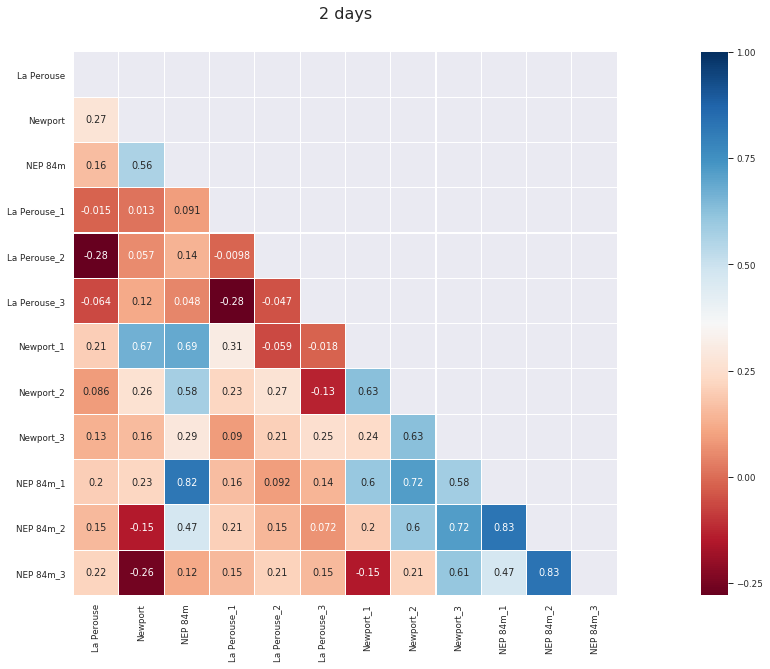

In [140]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
colormap = plt.cm.RdBu
plt.figure(figsize=(30,10))
plt.title(u'2 days', y=1.05, size=16)

mask = np.zeros_like(df_new.corr())
mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(df_new.corr(), mask=mask, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [125]:
range = pd.date_range('2013-08-01', '2013-08-31', freq='D')


# df_adcp = pd.DataFrame(index = range)

# df_adcp['ADCP 84m'] = north_84

wind_stress_adcp_corr = pd.DataFrame(index = range)
wind_stress_adcp_corr['La Perouse'] = df.La_Perouse_Wind_Stress.resample('D').mean()
wind_stress_adcp_corr['Newport'] = wind_stress_newport[211:-121]
wind_stress_adcp_corr['ADCP 148m'] = north_148
# wind_stress_adcp_corr['NEP 186m'] = v_unrotated[94:-55,25,j,i]

# daily_wind_stress['Newport'] = wind_stress_newport[211:-121]


In [126]:
NON_DER = mydates_Newport[211:-121]
df_new = df_derived_by_shift(wind_stress_adcp_corr, 3, NON_DER)

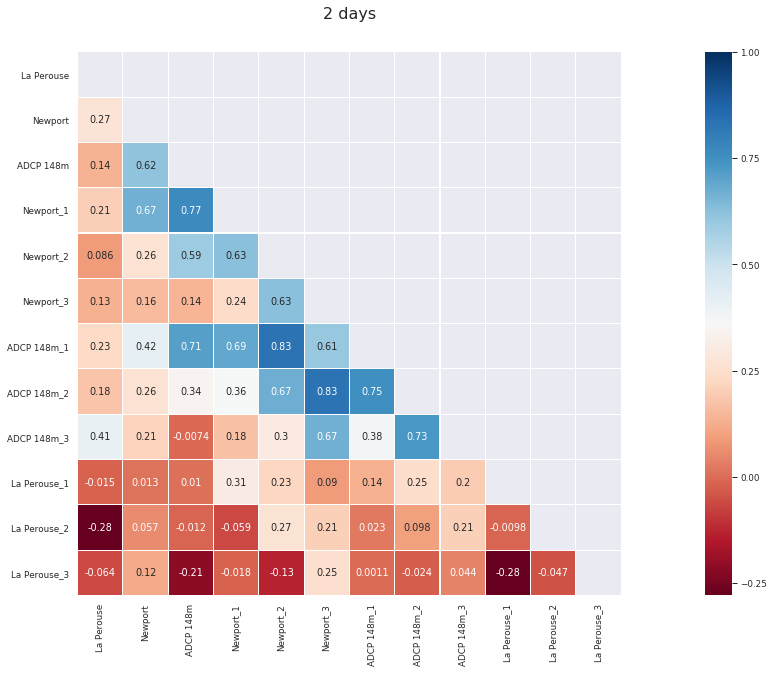

In [127]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
colormap = plt.cm.RdBu
plt.figure(figsize=(30,10))
plt.title(u'2 days', y=1.05, size=16)

mask = np.zeros_like(df_new.corr())
mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(df_new.corr(), mask=mask, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [128]:
range = pd.date_range('2013-08-01', '2013-08-31', freq='D')


# df_adcp = pd.DataFrame(index = range)

# df_adcp['ADCP 84m'] = north_84

wind_stress_adcp_corr = pd.DataFrame(index = range)
wind_stress_adcp_corr['La Perouse'] = df.La_Perouse_Wind_Stress.resample('D').mean()
wind_stress_adcp_corr['Newport'] = wind_stress_newport[211:-121]
wind_stress_adcp_corr['ADCP 196m'] = north_196
# wind_stress_adcp_corr['NEP 186m'] = v_unrotated[94:-55,25,j,i]

# daily_wind_stress['Newport'] = wind_stress_newport[211:-121]


In [129]:
NON_DER = mydates_Newport[211:-121]
df_new = df_derived_by_shift(wind_stress_adcp_corr, 3, NON_DER)

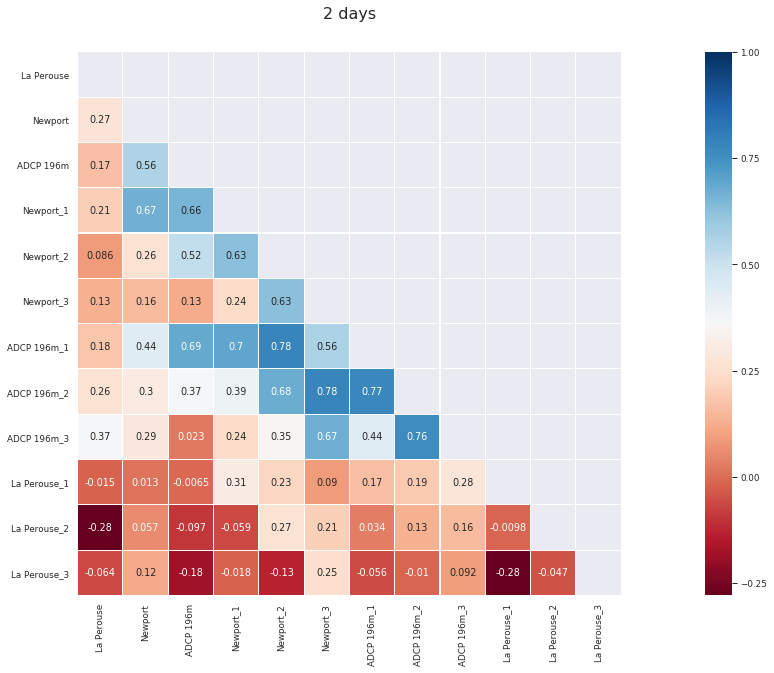

In [130]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
colormap = plt.cm.RdBu
plt.figure(figsize=(30,10))
plt.title(u'2 days', y=1.05, size=16)

mask = np.zeros_like(df_new.corr())
mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(df_new.corr(), mask=mask, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

## Points:

#### 1) The ADCP at 84m has a much better correlation with the wind stress at Newport as compared with the model at 15m (r = 0.66 vs 0.27)

#### 2) The Newport wind stress is nicely correlated with the NEP currents at 186m (r = 0.8 to 0.81) and ADCP at 148m (r = 0.77 to 0.83)

#### 3)  The same can be said for ADCP at 196 m (r = 0.66 to 0.78)

### Now we need to see why the surface currents in the model has poor correlation with the wind stress at Newport (is it due to an eddy ) ?

In [125]:
def plot_currents_A1_spatial(t, zlevel):  
    
    
    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

#     mbathy = mask.variables['mbathy'][0,220:280, 575:630]
    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][...]
    lat = bathy['nav_lat'][...]
    

        
    lon_A1 = -126.20433
    lat_A1 = 48.52958

    y, x = geo_tools.find_closest_model_point(lon_A1,lat_A1,\
                                          lon,lat,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 
        
    
    
#     y_wcvi_slice = np.array(np.arange(220,280))
#     x_wcvi_slice = np.array(np.arange(575,630))

    
#     u_falk = u_vel[t,:,40:100, 95:150]
#     v_falk = v_vel[t,:, 40:100, 95:150]
#     rho_falk = rho[t,:,40:100, 95:150]



    u_tzyx = np.empty((zlevels.shape[0],y_wcvi_slice.shape[0],x_wcvi_slice.shape[0]))
    v_tzyx = np.empty_like(u_tzyx)



    for level in np.arange(zlevels.shape[0]):
        u_tzyx[level,...], v_tzyx[level,...] = viz_tools.unstagger(u_vel[t,level,...], v_vel[t,level,...])
        
    u_tzyx_A1 = np.empty((zlevels.shape[0]))
    v_tzyx_A1 = np.empty_like(u_tzyx_A1)
        
    u_tzyx_A1[:] = u_tzyx[:,j,i]
    v_tzyx_A1[:] = v_tzyx[:,j,i]



#     cmap = plt.get_cmap(cmo.cm.balance)
#     cmap.set_bad('burlywood')
    cmap = plt.get_cmap('plasma')
    cmap.set_bad('#8b7765')

    fig, ax = plt.subplots(1, 1, figsize=(16,12)); ax.grid()
#     ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean(lon)))
    CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
    CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
    CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=16)
    CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=16)

#     q = ax.pcolormesh(x_wcvi_slice, y_wcvi_slice, val_iso[:], cmap=cmap, vmin= cmin, vmax= cmax)
#     cbar = fig.colorbar(q, ax=ax)

    
    

#     for i in np.arange(x.shape[0]):

    q = ax.scatter(x, y, s=500, alpha=0.5, edgecolor= 'cyan' )
    
#     cbar = fig.colorbar(q, ax=ax)
#     cbar.set_label(label='Spiciness', fontsize = 16)
#     cbar.ax.tick_params(labelsize=16) 
    speeds = np.sqrt(np.square(u_tzyx_A1) + np.square(v_tzyx_A1))
#     quiver = ax.quiver(x_wcvi_slice[::arrow_step], y_wcvi_slice[::arrow_step], u_rho_0[::arrow_step,::arrow_step], v_rho_0[::arrow_step,::arrow_step] , speeds[::arrow_step,::arrow_step], pivot='mid', cmap = cmap, width=0.005, minshaft= 0.5)
    quiver = ax.quiver(x, y, u_tzyx_A1[zlevel], v_tzyx_A1[zlevel] , color = 'red', pivot='tail', width=0.005, minshaft= 0.5)
    legend = ax.legend(loc='best', fancybox=True, framealpha=0.25, fontsize =16)
    ax.quiverkey(quiver, 610, 320,  0.2, r'0.2 m/sec', coordinates = 'data')
    
    ax.set_xlabel('x index', fontsize =16)
    ax.set_ylabel('y index', fontsize = 16)
    ax.tick_params(axis='both',labelsize =16)
    
    
    ax.set_title('Currents at A1 on {0} August 2013 at depth \u2248 {d:.1f} m'.format(t-94, d = zlevels[zlevel]), fontsize =16)


    
    viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
    viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')
#     ax.set_ylim(220,280)
#     ax.set_xlim(575,630)
    ax.grid()



In [79]:
sns.set_context('paper')

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)
/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


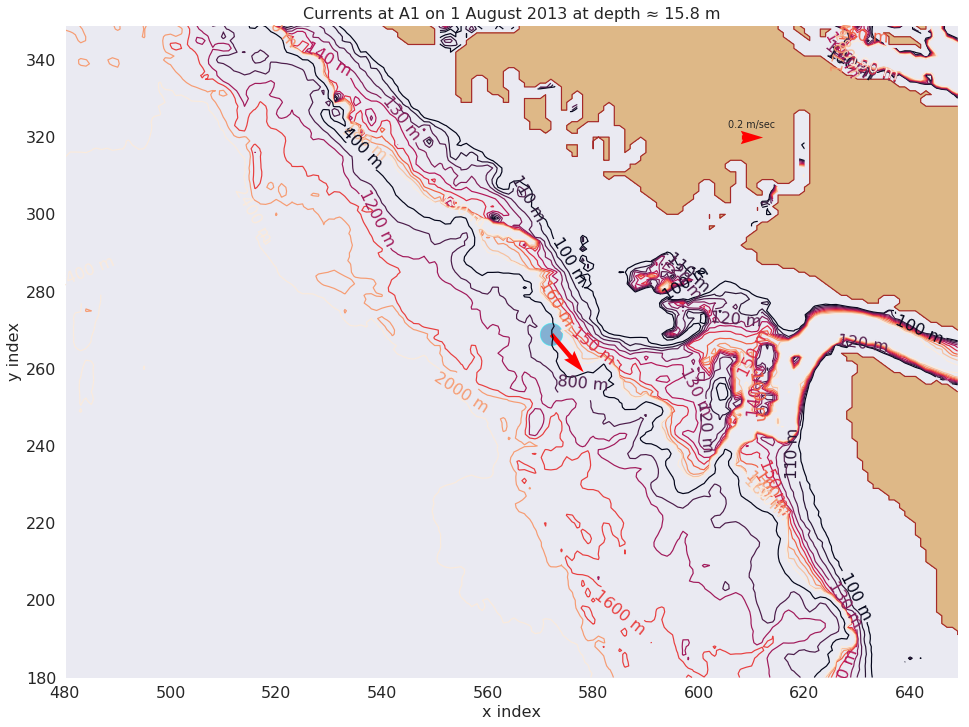

In [127]:
plot_currents_A1_spatial(t= 95, zlevel=10)

In [105]:
def plot_currents_spatial(t, zlevel):  
    
    
    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

#     mbathy = mask.variables['mbathy'][0,220:280, 575:630]
    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][...]
    lat = bathy['nav_lat'][...]
    

        
    lon_A1 = -126.20433
    lat_A1 = 48.52958

    y, x = geo_tools.find_closest_model_point(lon_A1,lat_A1,\
                                          lon,lat,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 
        
    
    
#     y_wcvi_slice = np.array(np.arange(220,280))
#     x_wcvi_slice = np.array(np.arange(575,630))

    
#     u_falk = u_vel[t,:,40:100, 95:150]
#     v_falk = v_vel[t,:, 40:100, 95:150]
#     rho_falk = rho[t,:,40:100, 95:150]



    u_tzyx = np.empty((zlevels.shape[0],y_wcvi_slice.shape[0],x_wcvi_slice.shape[0]))
    v_tzyx = np.empty_like(u_tzyx)



    for level in np.arange(zlevels.shape[0]):
        u_tzyx[level,...], v_tzyx[level,...] = viz_tools.unstagger(u_vel[t,level,...], v_vel[t,level,...])
        
    u_tzyx_A1 = np.empty((zlevels.shape[0]))
    v_tzyx_A1 = np.empty_like(u_tzyx_A1)
        
    u_tzyx_A1[:] = u_tzyx[:,j,i]
    v_tzyx_A1[:] = v_tzyx[:,j,i]



#     cmap = plt.get_cmap(cmo.cm.balance)
#     cmap.set_bad('burlywood')
    cmap = plt.get_cmap('plasma')
    cmap.set_bad('#8b7765')

    fig, ax = plt.subplots(1, 1, figsize=(16,12)); ax.grid()
#     ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean(lon)))
    CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
    CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
    CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=16)
    CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=16)

#     q = ax.pcolormesh(x_wcvi_slice, y_wcvi_slice, val_iso[:], cmap=cmap, vmin= cmin, vmax= cmax)
#     cbar = fig.colorbar(q, ax=ax)

    
    

#     for i in np.arange(x.shape[0]):

    q = ax.scatter(x, y, s=300, alpha=0.7, edgecolor= 'cyan', label = 'Station A1' )
    
#     cbar = fig.colorbar(q, ax=ax)
#     cbar.set_label(label='Spiciness', fontsize = 16)
#     cbar.ax.tick_params(labelsize=16) 
    speeds = np.empty_like(u_tzyx)
    speeds[zlevel] = np.sqrt(np.square(u_tzyx[zlevel,...]) + np.square(v_tzyx[zlevel,...]))
    
    arrow_step = 5
#     quiver = ax.quiver(x_wcvi_slice[::arrow_step], y_wcvi_slice[::arrow_step], u_rho_0[::arrow_step,::arrow_step], v_rho_0[::arrow_step,::arrow_step] , speeds[::arrow_step,::arrow_step], pivot='mid', cmap = cmap, width=0.005, minshaft= 0.5)
    quiver = ax.quiver(x_wcvi_slice[::arrow_step], y_wcvi_slice[::arrow_step], u_tzyx[zlevel,::arrow_step,::arrow_step], v_tzyx[zlevel,::arrow_step,::arrow_step] , speeds[zlevel,::arrow_step,::arrow_step], pivot='tail', width=0.005, minshaft= 0.5)
    legend = ax.legend(loc='upper right', fancybox=True, framealpha=0.25, fontsize =16)
    ax.quiverkey(quiver, 610, 320,  0.2, r'0.2 m/sec', coordinates = 'data')
    
    ax.set_xlabel('x index', fontsize =16)
    ax.set_ylabel('y index', fontsize = 16)
    ax.tick_params(axis='both',labelsize =16)
    
    
    ax.set_title('Currents on {0} August 2013 at depth \u2248 {d:.1f} m'.format(t-94, d = zlevels[zlevel]), fontsize =16)

    
    viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
    viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')
#     ax.set_ylim(220,280)
#     ax.set_xlim(575,630)
    ax.grid()



/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:59: RuntimeWarning: invalid value encountered in less


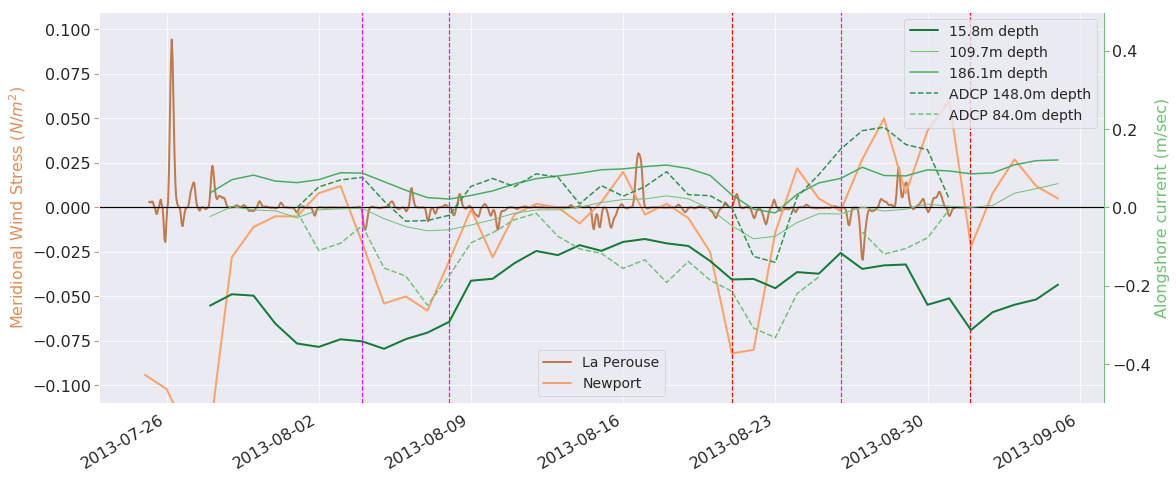

In [123]:

step = 1
window_size_1 = 12



time_axis = datetime_2013[::step]






s_v = v_wind[:]   
filt_v = smooth(s_v,window_size_1,'hanning')

s_u = u_wind[:]   
filt_u = smooth(s_u,window_size_1,'hanning')

s_wind = wind_spd[:]
filt_wind = smooth(s_wind,window_size_1,'hanning')

La_perouse_stress = np.sign(filt_v)*stress(sp=filt_v)




fig, ax1 = plt.subplots(1, 1, figsize=(18,8))

# ax1.plot(time_axis[1300:] ,filt_v[1300:], 'b-',linewidth=2, label = 'La Perouse')

ax1.plot(time_axis[1300:] , La_perouse_stress[1300:], color = colors[30],linewidth=2, label = 'La Perouse')

ax1.plot(mydates_Newport[204:-116], wind_stress_newport[204:-116], c = colors[40], linewidth=2, label = 'Newport')
# ax1.plot(time_axis_orford ,filt_v_orford[::step], 'cyan',linewidth=2)


# ax1.legend(['Filtered'])
# ax1.set_title("Meridional Wind speed", fontsize = 16)
ax1.axhline(y=0, color = 'k')
ax1.axvline(x = time_axis[1944], color = 'r', linestyle  = '--')
ax1.axvline(x = time_axis[-1], color = 'r', linestyle  = '--')
ax1.tick_params(axis='both',labelsize =16)
ax1.set_ylim(-0.11,0.11)
ax1.set_ylabel('Meridional Wind Stress ($N/m^2$)', fontsize = 16)# and Wind stress (*10^3) (N/m^2)', fontsize = 16)
ax1.grid()
ax1.legend(loc='best', fontsize = 14)
ax1.yaxis.label.set_color(colors[35])
ax1.tick_params(axis='both',labelsize =16, color = colors[35])

ax2 = ax1.twinx()
ax2.plot(mydates[90:-50], v_unrotated[90:-50,10,j,i], c = colors_speed[40], linewidth=2, label = '{0:0.1f}m depth'.format(zlevels[10]))
ax2.plot(mydates[90:-50], v_unrotated[90:-50,22,j,i], c = colors_speed[25], linewidth=1, label = '{0:0.1f}m depth'.format(zlevels[22]))
ax2.plot(mydates[90:-50], v_unrotated[90:-50,25,j,i], c = colors_speed[30], linewidth=1.5, label = '{0:0.1f}m depth'.format(zlevels[25]))


ax2.plot(mydates_A1_1, north_148, color = colors_speed[35], linewidth=1.5, linestyle = 'dashed', label = 'ADCP {0:0.1f}m depth'.format(148))

north_84[north_84 < -2] = 'Nan'
ax2.plot(mydates_A1_1, north_84, color = colors_speed[25], linewidth=1.5,linestyle = 'dashed', label = 'ADCP {0:0.1f}m depth'.format(84))
# # ax3 = ax1.twinx()
# # ax1.plot(mydates_Newport[1:-1], wind_stress_newport[:])#, 'golden', linewidth=2, label = 'Newport')
# # ax3.set_yticklabels([])

ax2.set_ylabel('Alongshore current (m/sec)', fontsize = 16)
ax2.set_ylim(-0.5, 0.5)
ax2.tick_params(axis='both',labelsize =16, color = colors_speed[25])
ax2.yaxis.label.set_color(colors_speed[25])
ax2.legend(loc = 'best', fontsize  =14)
ax2.spines['right'].set_color(colors_speed[25])

ax1.axvline(x = mydates[mydates == '2013-08-04'], color = 'magenta', linestyle  = '--')

ax1.axvline(x = mydates[mydates == '2013-08-08'], color = 'magenta', linestyle  = '--')

ax1.axvline(x = mydates[mydates == '2013-08-26'], color = 'magenta', linestyle  = '--')



# offset = 60
# new_fixed_axis = ax2.get_grid_helper().new_fixed_axis
# ax2.axis["right"] = new_fixed_axis(loc="right",
#                                     axes=ax2,
#                                     offset=(offset, 0))

fig.autofmt_xdate()



In [110]:
mydates[mydates == '2013-08-02']

DatetimeIndex(['2013-08-02'], dtype='datetime64[ns]', freq='D')

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


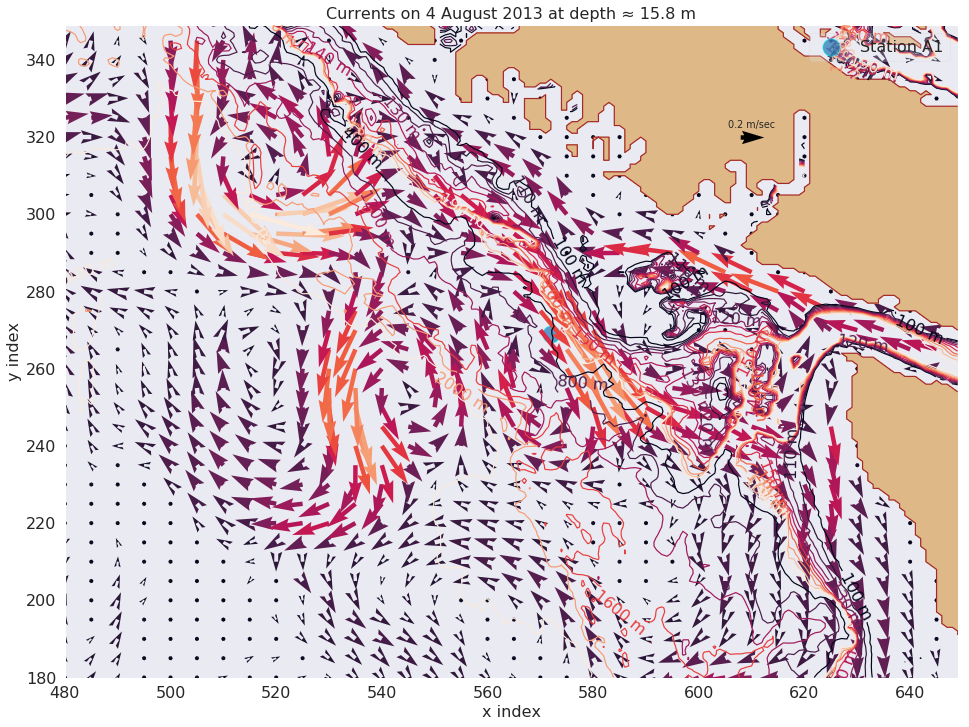

In [118]:
plot_currents_spatial(t=98, zlevel=10)

### Start of the month :Strong Coastal current close to the coast and strong upwelling current offshore (shelf break region) during strong upwelling winds

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


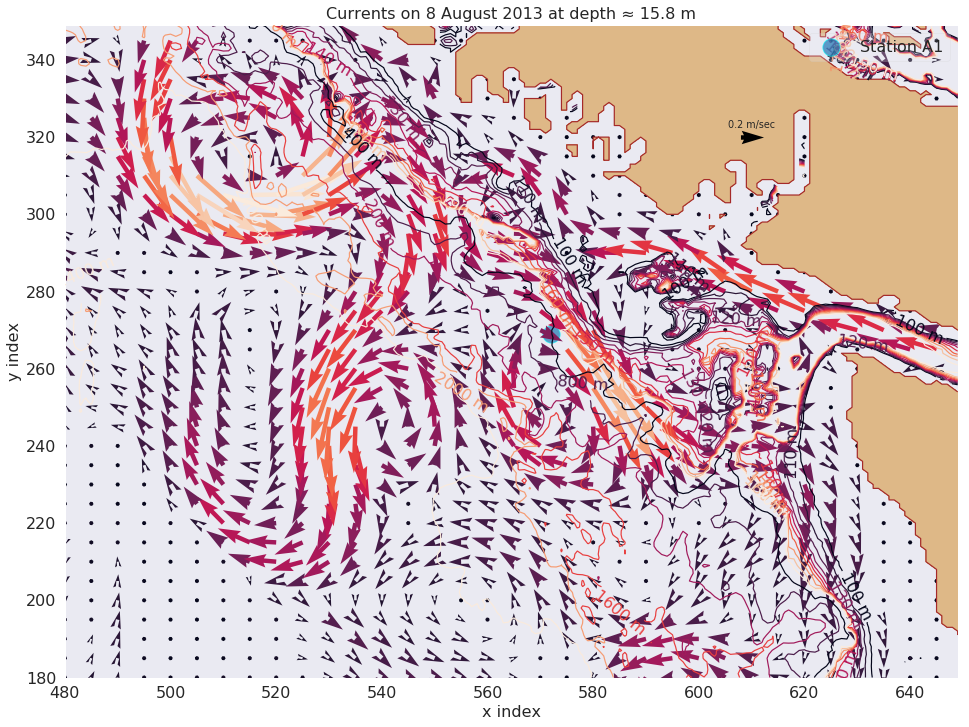

In [121]:
plot_currents_spatial(t=102, zlevel=10)

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


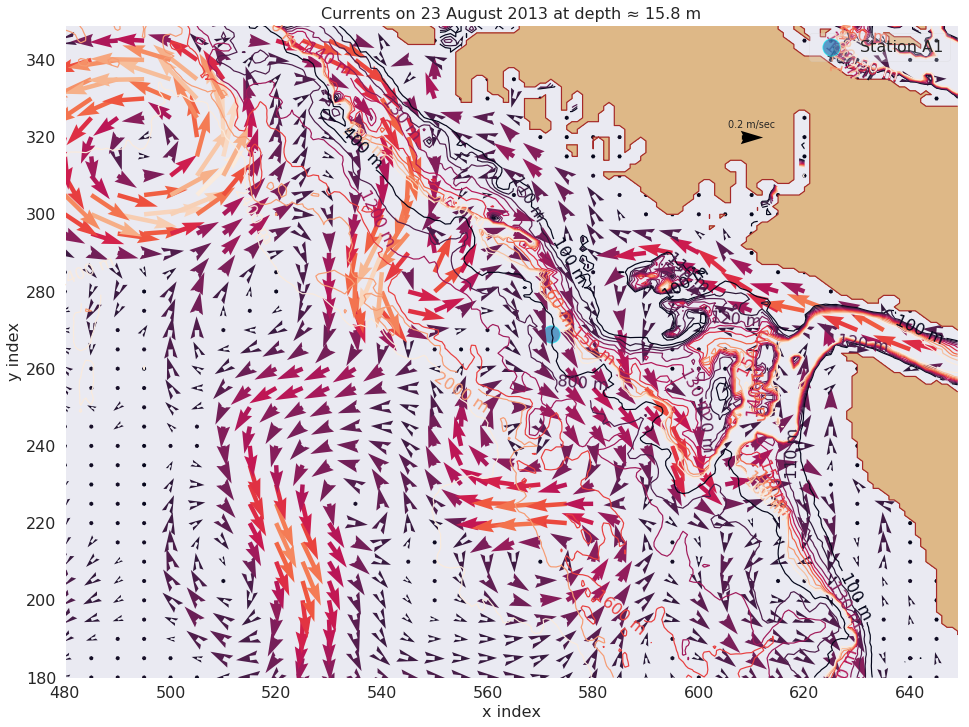

In [124]:
plot_currents_spatial(t=117, zlevel=10)

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


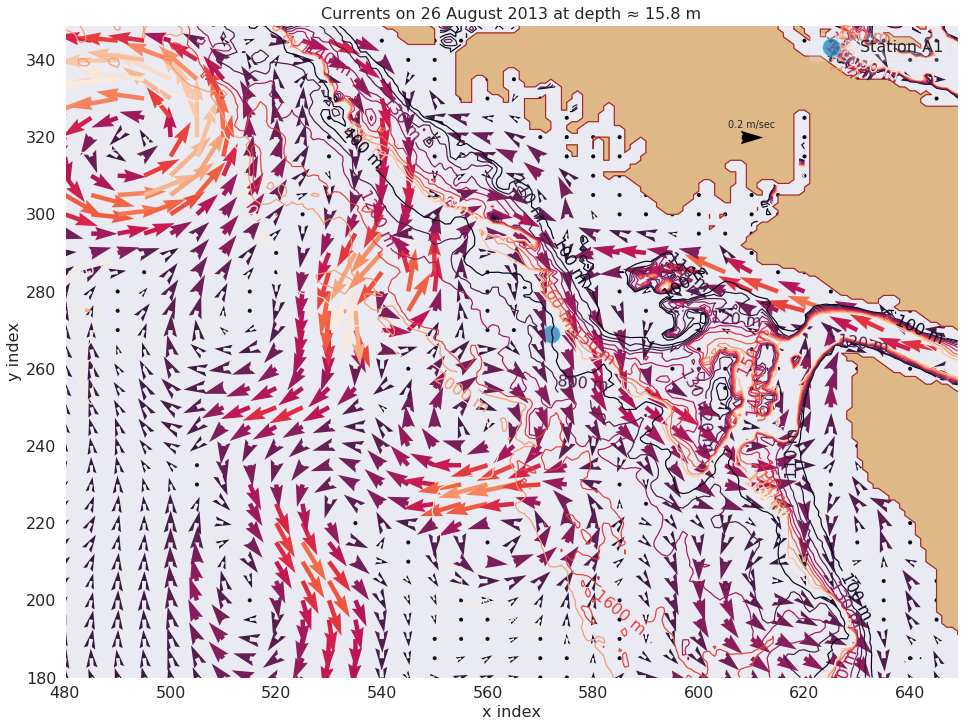

In [122]:
plot_currents_spatial(t=120, zlevel=10)

### End of August: Winds are predominantly northward but the station A1 seems to be situated in an eddy enclosed region which causes the currents (close to the surface) to be southward despite northward wind stress and poor correlation with winds 

In [30]:
x_wcvi_slice.shape

(170,)

In [140]:
bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

#     mbathy = mask.variables['mbathy'][0,220:280, 575:630]
Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]



lon_A1 = -126.20433
lat_A1 = 48.52958

y, x = geo_tools.find_closest_model_point(lon_A1,lat_A1,\
                                      lon,lat,grid='NEMO',tols=\
                                      {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                       'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

In [38]:
lon

array([[-142.28317261, -142.25552368, -142.22789001, ..., -122.71237946,
        -122.68501282, -122.65763855],
       [-142.28166199, -142.25401306, -142.22637939, ..., -122.71155548,
        -122.68418884, -122.6568222 ],
       [-142.28015137, -142.25250244, -142.22486877, ..., -122.71073151,
        -122.68336487, -122.65599823],
       ..., 
       [-138.12269592, -138.09686279, -138.07102966, ..., -120.59594727,
        -120.5721283 , -120.54830933],
       [-138.11502075, -138.08918762, -138.06335449, ..., -120.59220123,
        -120.56839752, -120.54458618],
       [-138.10734558, -138.08151245, -138.05569458, ..., -120.58846283,
        -120.56465912, -120.54085541]], dtype=float32)